# Age Estimation using the YOLO algorithm

Authors: Isak Killingrød, Jon A B Larssen, Jon I J Skånøy

About

## Setup

### Installation

In [ ]:
# Run installation


# Server
#!python -m pip install --upgrade pip 
#!python -m pip install requests tqdm torch torchvision pandas matplotlib pillow numpy opencv-python ipywidgets

In [2]:
%matplotlib inline
from tqdm.notebook import tqdm

### Global variables

In [3]:
USERNAME = 'adiencedb'
PASSWORD = 'adience'

In [ ]:
DATA_DIR = 'data'
STORAGE = 'YOLO_NB_CORS'

In [5]:
BASE_URL = 'http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/'

ARCHIVE_URL = BASE_URL + "faces.tar.gz"

CASCADE_FILENAME = "haarcascade_frontalface_default.xml"
CASCADE_URL = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'

In [6]:
AGE_CATEGORIES = [
    (0, 2), (4, 6), (8, 12), (15, 20), (25, 32), 
    (38, 43), 
    (48, 53), (60, 100)
]

### Imports

In [7]:
import os
import shutil
import requests
import tarfile
from tqdm.notebook import tqdm
from requests.auth import HTTPBasicAuth
import torch
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import re
import cv2
from concurrent.futures import ThreadPoolExecutor
from glob import glob
from pathlib import Path
import yaml
import json
from datetime import datetime
import optuna
from ultralytics import YOLO

### Config

In [8]:
# DO_TRAIN

In [ ]:
NUM_WORKERS = os.cpu_count() // 2 # For preprocessing, not tuning or training

In [10]:
ARCHIVE_PATH = os.path.join(DATA_DIR, "faces.tar.gz")

In [11]:
CASCADE_DIR = os.path.join(DATA_DIR, "haarcascades")
os.makedirs(CASCADE_DIR, exist_ok=True)
CASCADE_PATH = os.path.join(CASCADE_DIR, CASCADE_FILENAME)

### Functions

In [12]:
def show_sample_with_bbox(img_path, label_path):
    """Display an image with its bounding box"""
    # Load image
    img = Image.open(img_path)
    img_w, img_h = img.size
    
    # Load label
    with open(label_path, 'r') as f:
        line = f.readline().strip().split()
        class_id = int(line[0])
        x_center, y_center, width, height = map(float, line[1:5])
    
    # Convert YOLO format to pixel coordinates
    x1 = int((x_center - width/2) * img_w)
    y1 = int((y_center - height/2) * img_h)
    x2 = int((x_center + width/2) * img_w)
    y2 = int((y_center + height/2) * img_h)
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(np.array(img))
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
    
    # Label with age category
    age_category = creator.age_categories[class_id]
    plt.title(f"Age Category: {age_category[0]}-{age_category[1]} years")
    plt.axis('off')
    plt.show()

In [13]:
def get_model_filename(version, size):
    """
    Returns the correct YOLO model filename based on version and size.
    Only supports detection models.

    Args:
        version (int or str): YOLO version (8–12)
        size (str): Model size, depends on version

    Returns:
        str: Filename of the model checkpoint, e.g. 'yolov9e.pt'

    Raises:
        ValueError: If version or size is unsupported
    """
    version = str(version).lower()
    size = size.lower()

    version_size_map = {
        '8':  ['n', 's', 'm', 'l', 'x'],
        '9':  ['t', 's', 'm', 'c', 'e'],  # mapped sizes
        '10': ['n', 's', 'm', 'b', 'l', 'x'],
        '11': ['n', 's', 'm', 'l', 'x'],
        '12': ['n', 's', 'm', 'l', 'x'],
    }

    if version not in version_size_map:
        raise ValueError(f"Unsupported YOLO version '{version}'.")

    if size not in version_size_map[version]:
        raise ValueError(f"Unsupported size '{size}' for YOLOv{version}.")

    # Explicit mapping for YOLOv9
    if version == '9':
        model_map = {
            'n': 'yolov9t.pt',
            's': 'yolov9s.pt',
            'm': 'yolov9m.pt',
            'l': 'yolov9c.pt',
            'x': 'yolov9e.pt',
        }
        return model_map[size]

    # General naming rules
    if version in ['8', '10']:
        return f'yolov{version}{size}.pt'
    elif version in ['11', '12']:
        return f'yolo{version}{size}.pt'


In [14]:
def get_all_data_yaml_paths(base_dir):
    return sorted([
        str(p) for p in Path(base_dir).rglob("data.yaml")
        if "size_" in str(p)
    ])


In [15]:
def run_all_datasets_optuna_and_training(
    base_dataset_dir='data/age_dataset',
    model_sizes=['n', 's', 'm', 'l', 'x'],
    model_versions=[8, 9, 10, 11, 12],
    image_sizes=[320, 416, 640],
    n_trials=10,
    epochs_per_trial=40,
    final_epochs=100,
    device='0',
    output_base='runs/age_exp'
):
    """
    Grid search over datasets, model versions, and model sizes with Optuna tuning.

    Args:
        base_dataset_dir: Root dir with YOLO-style datasets (per image size)
        model_sizes: List of model sizes per version (e.g., ['n', 's', ...])
        model_versions: List of YOLO model versions (e.g., [8, 9, 10, ...])
        image_sizes: List of dataset image sizes to include (e.g., [320, 416, 640])
        n_trials: Optuna trials per combination
        epochs_per_trial: Epochs during Optuna tuning
        final_epochs: Final training epochs
        device: Device to use (e.g., '0', 'cpu')
        output_base: Output directory base
        run_final_training: If True, run final training after tuning
    """

    for imgsz in image_sizes:
        data_yaml = os.path.join(base_dataset_dir, f"size_{imgsz}", "data.yaml")

        if not os.path.exists(data_yaml):
            print(f"⚠️  Skipping missing dataset: {data_yaml}")
            continue

        print(f"\n📂 Evaluating dataset: {data_yaml}")

        for version in model_versions:
            for size in model_sizes:
                try:
                    model_filename = get_model_filename(version, size)
                except ValueError as e:
                    print(f"⏭️ Skipping unsupported model: YOLOv{version}-{size} ({e})")
                    continue

                dataset_name = Path(data_yaml).parent.name
                run_name = f"v{version}_{size}_{imgsz}"
                output_dir = os.path.join(output_base, run_name)

                print(f"\n{'='*100}")
                print(f"🧪 Tuning: YOLOv{version}-{size} on dataset {dataset_name} ({imgsz}px)")
                print(f"{'='*100}")

                best_params, best_value = run_optuna_tuning(
                    data_yaml=data_yaml,
                    model_size=size,
                    model_version=version,
                    output_dir=output_dir,
                    n_trials=n_trials,
                    epochs_per_trial=epochs_per_trial,
                    device=device
                )


In [16]:
def run_optuna_tuning(
    data_yaml,
    model_size='n',
    output_dir='runs/tune_optuna',
    n_trials=40,
    epochs_per_trial=50,
    model_version=8,
    device='0'
):
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)

    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)

    dataset_dir = os.path.dirname(os.path.abspath(data_yaml))
    size_match = re.search(r"size_(\d+)", dataset_dir)
    imgsz = int(size_match.group(1)) if size_match else 416

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    run_name = f"optuna_v{model_version}_{model_size}_{imgsz}_{timestamp}"
    output_path = os.path.join(output_dir, run_name)
    os.makedirs(output_path, exist_ok=True)

    try:
        model_path = get_model_filename(model_version, model_size)
    except ValueError as e:
        print(f"❌ Invalid model request: {e}")
        return {}, 0.0

    def objective(trial):
        params = {
            'lr0': trial.suggest_float('lr0', 1e-5, 1e-2, log=True),
            'lrf': trial.suggest_float('lrf', 0.01, 0.2),
            'momentum': trial.suggest_float('momentum', 0.8, 0.95),
            'weight_decay': trial.suggest_float('weight_decay', 1e-4, 1e-3, log=True),
            'warmup_epochs': trial.suggest_int('warmup_epochs', 1, 5),
            'warmup_momentum': trial.suggest_float('warmup_momentum', 0.5, 0.95),
            'box': trial.suggest_float('box', 0.0, 8.0),
            'cls': trial.suggest_float('cls', 0.0, 1.0),
            'hsv_h': trial.suggest_float('hsv_h', 0.0, 1.0),
            'hsv_s': trial.suggest_float('hsv_s', 0.0, 1.0),
            'hsv_v': trial.suggest_float('hsv_v', 0.0, 1.0),
            'degrees': trial.suggest_float('degrees', 0.0, 180.0),
            'translate': trial.suggest_float('translate', 0.0, 1.0),
            'scale': trial.suggest_float('scale', 0.0, 1.0),
            'flipud': trial.suggest_float('flipud', 0.0, 1.0),
            'fliplr': trial.suggest_float('fliplr', 0.0, 1.0),
            'bgr': trial.suggest_float('bgr', 0.0, 1.0),
            'mixup': trial.suggest_float('mixup', 0.0, 1.0),
            'batch': trial.suggest_categorical('batch', [8, 16, 32]),
            'imgsz': imgsz,
            'optimizer': 'AdamW'
        }

        try:
            model = YOLO(model_path)
            results = model.train(
                data=data_yaml,
                cache='disk',
                workers=1,
                epochs=epochs_per_trial,
                device=device,
                verbose=False,
                plots=True,
                **params
            )
            return float(results.fitness) if hasattr(results, 'fitness') else 0.0
        except Exception as e:
            print(f"❌ Trial failed with error: {e}")
            return 0.0

    study = optuna.create_study(
        direction='maximize',
        study_name=f"yolo_v{model_version}{model_size}_img{imgsz}",
        storage=f"sqlite:///{STORAGE}.db",
        load_if_exists=True
    )
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_value = study.best_value

    with open(os.path.join(output_path, f'best_params_v{model_version}_{model_size}.json'), 'w') as f:
        json.dump(best_params, f, indent=4)

    print(f"\n✅ Best result for YOLOv{model_version}-{model_size} ({imgsz}px): {best_value:.4f}")
    return best_params, best_value


In [ ]:
def find_max_batch_size(model_path, imgsz, device='cuda:0', min_batch=8, max_batch=512):
    try:
        model = YOLO(model_path)
        model.model = model.model.to(device)
    except Exception as e:
        print(f"❌ Could not load model {model_path}: {e}")
        return None

    batch = max_batch
    while batch >= min_batch:
        try:
            dummy = torch.zeros((batch, 3, imgsz, imgsz)).to(device)
            with torch.no_grad():
                _ = model.model(dummy)
            return batch  
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                torch.cuda.empty_cache()
                batch //= 2
            else:
                print(f"❌ Runtime error (non-OOM) for {model_path}: {e}")
                return None
        except Exception as e:
            print(f"❌ Other error for {model_path}: {e}")
            return None
    return None

### Classes

In [18]:
class FaceAgeDatasetCreator:
    def __init__(
        self,
        base_dir="data",
        faces_archive=None,
        faces_dir=None,
        output_dir=None,
        cascade_dir=None,
        fold_files=None,
        img_size=416,
        max_workers=4
    ):
        self.base_dir = base_dir
        os.makedirs(self.base_dir, exist_ok=True)
        
        self.faces_archive = faces_archive or os.path.join(base_dir, "faces.tar.gz")
        self.faces_dir = faces_dir or os.path.join(base_dir, "faces")
        self.output_dir = output_dir or os.path.join(base_dir, "age_dataset")
        self.cascade_dir = cascade_dir or os.path.join(base_dir, "haarcascades")

        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.cascade_dir, exist_ok=True)

        if fold_files is None:
            self.fold_files = [
                os.path.join(base_dir, f"fold_{i}_data.txt") for i in range(5)
            ]
        else:
            self.fold_files = fold_files

        self.img_sizes = img_size if isinstance(img_size, list) else [img_size]
        self.img_size = self.img_sizes[0]

        self.age_categories = [
            (0, 2), (4, 6), (8, 12), (15, 20), (25, 32),
            (38, 43), (48, 53), (60, 100)
        ]

        self.max_workers = max_workers or (os.cpu_count() // 2)

        try:
            self.opencv_available = True
            self.face_cascade = self.load_cascade()
        except ImportError:
            self.opencv_available = False
            self.face_cascade = None
            print("OpenCV not available. Face detection disabled.")

    def load_cascade(self):
        paths = [
            # cv2.data.haarcascades + 'haarcascade_frontalface_default.xml',
            os.path.join(self.cascade_dir, 'haarcascade_frontalface_default.xml'),
            'haarcascade_frontalface_default.xml'
        ]
        for path in paths:
            if os.path.exists(path):
                cascade = cv2.CascadeClassifier(path)
                if cascade.empty():
                    print(f"Warning: Failed to load cascade from {path}")
                else:
                    return cascade
        print("Cascade not found or failed to load.")
        return None

    def extract_faces_archive(self):
        if not os.path.exists(self.faces_dir):
            os.makedirs(self.faces_dir, exist_ok=True)
            print(f"Extracting {self.faces_archive} to {self.faces_dir}...")
            with tarfile.open(self.faces_archive, 'r:gz') as tar:
                for member in tqdm(tar.getmembers(), desc="Extracting faces"):
                    if member.name.startswith("faces/"):
                        member.name = member.name[len("faces/"):]
                        if member.name:
                            tar.extract(member, self.faces_dir, filter='data')
            print("Extraction complete.")
        else:
            print(f"{self.faces_dir} already exists. Skipping extraction.")

    def get_age_class(self, age_info):
        try:
            if isinstance(age_info, str) and '(' in age_info:
                match = re.findall(r'\d+', age_info)
                if len(match) >= 2:
                    lower, upper = int(match[0]), int(match[1])
                    for i, cat in enumerate(self.age_categories):
                        if (lower, upper) == cat:
                            return i
            else:
                age = int(age_info)
                for i, (low, high) in enumerate(self.age_categories):
                    if low <= age <= high:
                        return i
            return -1
        except:
            return -1

    def load_fold_data(self, fold_files=None):
        if fold_files is None:
            fold_files = self.fold_files
        all_data = []
        column_names = [
            'user_id', 'original_image', 'face_id', 'age', 'gender', 
            'x', 'y', 'dx', 'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'
        ]
        for fold_file in fold_files:
            try:
                df = pd.read_csv(fold_file, sep='\t', header=None, names=column_names)
                df['age_class'] = df['age'].apply(self.get_age_class)
                df = df[df['age_class'] != -1]
                all_data.append(df)
            except Exception as e:
                print(f"Error loading {fold_file}: {e}")
        return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame(columns=column_names + ['age_class'])

    def get_image_path(self, row):
        filename = f"coarse_tilt_aligned_face.{row['face_id']}.{row['original_image']}"
        return os.path.join(self.faces_dir, str(row['user_id']), filename)

    def detect_face(self, image_np):
        if not self.opencv_available:
            return None
    
        try:
            cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            if cascade.empty():
                print("Failed to load cascade.")
                return None
            gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
            faces = cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
            return max(faces, key=lambda r: r[2] * r[3]) if len(faces) > 0 else None
        except Exception as e:
            print(f"Face detection failed: {e}")
            return None

    def is_dataset_complete(self, size_dir):
        """
        Check if the dataset for a given image size is complete and ready.
        """
        expected = [
            os.path.join(size_dir, "data.yaml"),
            os.path.join(size_dir, "classes.txt"),
            os.path.join(size_dir, "images/train"),
            os.path.join(size_dir, "images/val"),
            os.path.join(size_dir, "labels/train"),
            os.path.join(size_dir, "labels/val"),
        ]
        for path in expected:
            if not os.path.exists(path):
                return False
        
        val_imgs = list(Path(size_dir).joinpath("images/val").glob("*.jpg"))
        val_lbls = list(Path(size_dir).joinpath("labels/val").glob("*.txt"))
        
        return len(val_imgs) > 0 and len(val_imgs) == len(val_lbls)

    def process_dataset(self, data, img_dir, label_dir):
        os.makedirs(img_dir, exist_ok=True)
        os.makedirs(label_dir, exist_ok=True)

        transform = transforms.Resize((self.img_size, self.img_size))

        def process_row(idx_row):
            idx, row = idx_row
            try:
                img_path = self.get_image_path(row)
                if not os.path.exists(img_path):
                    return
        
                with Image.open(img_path).convert('RGB') as img:
                    orig_width, orig_height = img.size
                    img_resized = transform(img)
        
                    img_np = np.array(img)
                    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
                    face_coords = self.detect_face(img_cv)
        
                    filename = os.path.basename(img_path).replace('coarse_tilt_aligned_face.', '')
                    base_filename = f"{idx}_{filename.split('.')[0]}"
                    save_path = os.path.join(img_dir, f"{base_filename}.jpg")
                    img_resized.save(save_path)
        
                    # Handle YOLO box
                    if face_coords is not None and isinstance(face_coords, (tuple, list, np.ndarray)):
                        x, y, w, h = face_coords
                        x_center = (x + w / 2) / orig_width
                        y_center = (y + h / 2) / orig_height
                        width_norm = w / orig_width
                        height_norm = h / orig_height
                    else:
                        x_center, y_center = 0.5, 0.5
                        width_norm, height_norm = 0.8, 0.8
        
                    # Clamp
                    x_center = max(0, min(1, x_center))
                    y_center = max(0, min(1, y_center))
                    width_norm = max(0.05, min(1, width_norm))
                    height_norm = max(0.05, min(1, height_norm))
        
                    class_id = int(row['age_class'])
                    if not (0 <= class_id < len(self.age_categories)):
                        print(f"Invalid age class at index {idx}: {class_id}")
                        return
        
                    label_path = os.path.join(label_dir, f"{base_filename}.txt")
                    with open(label_path, 'w') as f:
                        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
        
            except Exception as e:
                print(f"Error at index {idx}: {e}")


        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            list(tqdm(executor.map(process_row, data.iterrows()), total=len(data)))

    def create_data_yaml_for_size(self, output_dir):
        yaml_path = os.path.join(output_dir, 'data.yaml')
        with open(yaml_path, 'w') as f:
            train_dir = os.path.abspath(os.path.join(output_dir, "images/train"))
            val_dir = os.path.abspath(os.path.join(output_dir, "images/val"))
            f.write(f"train: {train_dir}\n")
            f.write(f"val: {val_dir}\n")
            f.write(f"nc: {len(self.age_categories)}\n")
            f.write("names:\n")
            classes_path = os.path.join(output_dir, 'classes.txt')
            with open(classes_path, 'r') as cf:
                for i, line in enumerate(cf):
                    f.write(f"  {i}: '{line.strip()}'\n")

    def create_yolo_dataset(self, train_folds=[0, 1, 2, 3], val_fold=4, specific_sizes=None):
        sizes_to_process = specific_sizes if specific_sizes else self.img_sizes
        for img_size in sizes_to_process:
            size_dir = os.path.join(self.output_dir, f"size_{img_size}")
    
            if not self.is_dataset_complete(size_dir):
                print(f"\n=== Processing for image size {img_size}x{img_size} ===")
                self.img_size = img_size
                img_train, img_val = os.path.join(size_dir, 'images/train'), os.path.join(size_dir, 'images/val')
                lbl_train, lbl_val = os.path.join(size_dir, 'labels/train'), os.path.join(size_dir, 'labels/val')
                for d in [img_train, img_val, lbl_train, lbl_val]:
                    os.makedirs(d, exist_ok=True)
    
                with open(os.path.join(size_dir, 'classes.txt'), 'w') as f:
                    for (low, high) in self.age_categories:
                        f.write(f"age_{low}_{high}\n")
    
                train_data = self.load_fold_data([self.fold_files[i] for i in train_folds])
                val_data = self.load_fold_data([self.fold_files[val_fold]])
    
                print(f"Train images: {len(train_data)}, Val images: {len(val_data)}")
    
                self.process_dataset(train_data, img_train, lbl_train)
                self.process_dataset(val_data, img_val, lbl_val)
                self.create_data_yaml_for_size(size_dir)
                print(f"✅ Dataset ready at: {size_dir}")
            else:
                print(f"✅ {size_dir} already complete. Skipping...")


## Download data

### Session

In [19]:
session = requests.Session()
session.headers.update({
    "User-Agent": "Mozilla/5.0",
    "Referer": BASE_URL
})

### Folds

In [20]:
fold_files = [f"fold_{i}_data.txt" for i in range(5)]

for fname in fold_files:
    url = BASE_URL + fname
    dest = os.path.join(DATA_DIR, fname)
    
    if os.path.exists(dest):
        print(f"{dest} already exist")
        continue

    print(f"Downloading {url}")
    
    response = session.get(url, auth=HTTPBasicAuth(USERNAME, PASSWORD))
    
    if response.status_code == 200:
        with open(dest, 'wb') as f:
            f.write(response.content)
        print(f"Saved: {dest}")
    else:
        print(f"Failed: {url} (Status: {response.status_code})")

data\fold_0_data.txt already exist
data\fold_1_data.txt already exist
data\fold_2_data.txt already exist
data\fold_3_data.txt already exist
data\fold_4_data.txt already exist


### Faces

In [21]:
if not os.path.exists(ARCHIVE_PATH):
    print(f"\nDownloading archive: {ARCHIVE_URL}")
    response = session.get(ARCHIVE_URL, auth=HTTPBasicAuth(USERNAME, PASSWORD), stream=True)

    if response.status_code == 200:
        total_size = int(response.headers.get('content-length', 0))
        chunk_size = 8192

        with open(ARCHIVE_PATH, 'wb') as f, tqdm(
            desc="Downloading faces.tar.gz",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    bar.update(len(chunk))
        
        print(f"Downloaded: {ARCHIVE_PATH}")
    else:
        print(f"Failed to download archive (Status: {response.status_code})")
else:
    print(f"{ARCHIVE_PATH} already exist")

data\faces.tar.gz already exist


### Haar Cascade

In [22]:
if not os.path.exists(CASCADE_PATH):
    print(f"\nDownloading Haar cascade: {CASCADE_FILENAME}")
    try:
        response = requests.get(CASCADE_URL, stream=True)
        if response.status_code == 200:
            with open(CASCADE_PATH, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded cascade file to: {CASCADE_PATH}")
        else:
            print(f"Failed to download cascade file (Status: {response.status_code})")
    except Exception as e:
        print(f"Error downloading cascade file: {e}")
else:
    print(f"Cascade file already exists: {CASCADE_PATH}")

Cascade file already exists: data\haarcascades\haarcascade_frontalface_default.xml


## Preprocess data

In [23]:
creator = FaceAgeDatasetCreator(
    base_dir=DATA_DIR,
    img_size=[640, 416, 320],
    max_workers=NUM_WORKERS
)

### Folds

In [24]:
fold_files = creator.fold_files
print(f"Looking for fold files: {fold_files}")

Looking for fold files: ['data\\fold_0_data.txt', 'data\\fold_1_data.txt', 'data\\fold_2_data.txt', 'data\\fold_3_data.txt', 'data\\fold_4_data.txt']


In [25]:
data = creator.load_fold_data()
print(f"Loaded {len(data)} records from fold files")

Loaded 17411 records from fold files



Sample data:


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,age_class
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,4
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,4
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,4
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,4
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,4


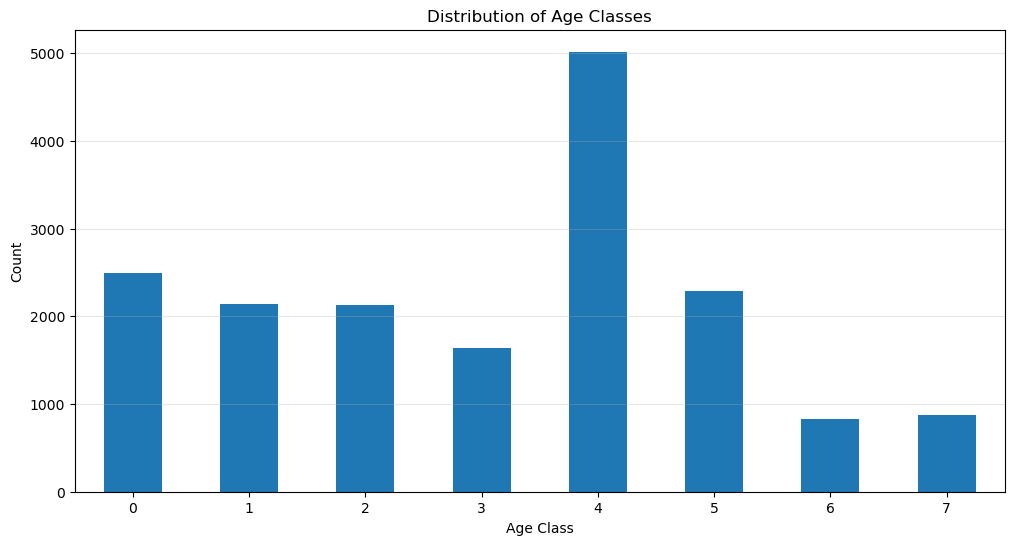

In [26]:
if len(data) > 0:
    print("\nSample data:")
    display(data.head())
    
    # Show age distribution
    plt.figure(figsize=(12, 6))
    data['age_class'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Age Classes')
    plt.xlabel('Age Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

### Extract faces

In [27]:
creator.extract_faces_archive()

data\faces already exists. Skipping extraction.


### Generate dataset

In [28]:
creator.create_yolo_dataset(train_folds=[0, 1, 2, 3], val_fold=4)

✅ data\age_dataset\size_640 already complete. Skipping...
✅ data\age_dataset\size_416 already complete. Skipping...
✅ data\age_dataset\size_320 already complete. Skipping...


## Hyperparameter tuning

In [ ]:
run_all_datasets_optuna_and_training(
    base_dataset_dir='data/age_dataset',
    model_sizes=['n', 's', 'm', 'l','x'],
    model_versions=[8,9,10,11,12], 
    image_sizes=[320,416,640],
    n_trials=5, # per combination
    epochs_per_trial=10,
    final_epochs=100,
    device='0',
    output_base='runs/age_exp'
)


📂 Evaluating dataset: data/age_dataset\size_320\data.yaml

🧪 Tuning: YOLOv8-n on dataset size_320 (320px)


[I 2025-04-26 02:32:19,177] Using an existing study with name 'yolo_v8n_img320' instead of creating a new one.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:33<00:00, 407.66it/s]


train: New cache created: B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache


train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:55<00:00, 249.44it/s]


val: Fast image access  (ping: 0.30.4 ms, read: 1.60.3 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:08<00:00, 455.61it/s]


val: New cache created: B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache


val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:11<00:00, 325.20it/s] 


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: AdamW(lr=1.0029404665992801e-05, momentum=0.8991371269314565) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008779672374176535), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.07G     0.3937      0.938      1.064          4        320: 100%|██████████| 430/430 [03:04<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:27<00:00,  2.07it/s]


                   all       3679       3679      0.125      0.967      0.139     0.0889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.34G      0.264     0.8354     0.9825          4        320: 100%|██████████| 430/430 [01:07<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]


                   all       3679       3679      0.126      0.942      0.145      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.36G     0.2224     0.8063     0.9657          4        320: 100%|██████████| 430/430 [01:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]


                   all       3679       3679      0.131      0.835      0.156      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.37G     0.2002     0.7865     0.9576          4        320: 100%|██████████| 430/430 [01:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]


                   all       3679       3679      0.131      0.905      0.173      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.38G     0.1939     0.7727      0.955          4        320: 100%|██████████| 430/430 [01:02<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]


                   all       3679       3679      0.133      0.797      0.186      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       1.4G     0.1868      0.762     0.9528          4        320: 100%|██████████| 430/430 [01:02<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.41it/s]


                   all       3679       3679      0.143      0.787      0.193      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.41G     0.1824     0.7548     0.9469          4        320: 100%|██████████| 430/430 [01:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:23<00:00,  2.45it/s]


                   all       3679       3679      0.135      0.783      0.201       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.43G     0.1771     0.7482      0.949          4        320: 100%|██████████| 430/430 [01:02<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:23<00:00,  2.46it/s]


                   all       3679       3679      0.136       0.78      0.206      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.45G     0.1748     0.7441      0.948          4        320: 100%|██████████| 430/430 [01:01<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:23<00:00,  2.44it/s]


                   all       3679       3679       0.26      0.757      0.212      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.46G     0.1728     0.7418     0.9497          4        320: 100%|██████████| 430/430 [01:02<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:23<00:00,  2.46it/s]


                   all       3679       3679      0.257      0.749      0.215      0.209

10 epochs completed in 0.280 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:27<00:00,  2.08it/s]


                   all       3679       3679      0.257       0.75      0.215      0.209
Speed: 0.2ms preprocess, 0.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train


[I 2025-04-26 02:51:58,972] Trial 9 finished with value: 0.2099953139735518 and parameters: {'lr0': 1.0029404665992801e-05, 'lrf': 0.07355951810728166, 'momentum': 0.8991371269314565, 'weight_decay': 0.0008779672374176535, 'warmup_epochs': 3, 'warmup_momentum': 0.7472622320772705, 'box': 6.7948706597525526, 'cls': 0.2273770783952377, 'hsv_h': 0.3632995230778292, 'hsv_s': 0.8392132035007263, 'hsv_v': 0.5122051163559461, 'degrees': 155.09934342711983, 'translate': 0.5214686338207111, 'scale': 0.5097009308583023, 'flipud': 0.46743883224927807, 'fliplr': 0.5925777900889831, 'bgr': 0.3930382652510095, 'mixup': 0.08201972092606735, 'batch': 32}. Best is trial 9 with value: 0.2099953139735518.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:01<00:00, 7037.46it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 78.914.5 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7605.64it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: AdamW(lr=0.002397524895029719, momentum=0.8351819743526487) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00011580906927953925), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.459G    0.05149     0.5094     0.9985          4        320: 100%|██████████| 1717/1717 [03:34<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.23it/s]

                   all       3679       3679      0.277      0.717      0.248      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.479G    0.03753     0.4452      0.951          4        320: 100%|██████████| 1717/1717 [03:18<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.25it/s]

                   all       3679       3679      0.311      0.761       0.26      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.479G    0.03136     0.4269     0.9367          4        320: 100%|██████████| 1717/1717 [03:14<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.36it/s]

                   all       3679       3679      0.311      0.764      0.283      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.479G      0.028     0.4189     0.9306          4        320: 100%|██████████| 1717/1717 [03:14<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.29it/s]

                   all       3679       3679      0.325      0.715       0.28      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.479G    0.02549     0.4115     0.9275          4        320: 100%|██████████| 1717/1717 [03:14<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.25it/s]


                   all       3679       3679      0.332      0.729      0.288       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.479G    0.02302     0.4079      0.923          4        320: 100%|██████████| 1717/1717 [03:14<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.38it/s]

                   all       3679       3679      0.205      0.766       0.29      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.479G    0.02112     0.4015     0.9203          4        320: 100%|██████████| 1717/1717 [03:15<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.38it/s]

                   all       3679       3679       0.21      0.742      0.294       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.479G    0.01962     0.3965     0.9206          4        320: 100%|██████████| 1717/1717 [03:15<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.40it/s]

                   all       3679       3679      0.335      0.688       0.31      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.479G    0.01825       0.39      0.917          4        320: 100%|██████████| 1717/1717 [03:24<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:34<00:00,  6.69it/s]

                   all       3679       3679      0.441      0.685      0.329      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.479G    0.01657      0.384      0.916          4        320: 100%|██████████| 1717/1717 [03:17<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.39it/s]


                   all       3679       3679      0.363       0.72      0.337      0.337

10 epochs completed in 0.642 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:30<00:00,  7.45it/s]


                   all       3679       3679      0.363       0.72      0.338      0.337
Speed: 0.3ms preprocess, 1.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train2


[I 2025-04-26 03:31:33,308] Trial 10 finished with value: 0.3373486351539138 and parameters: {'lr0': 0.002397524895029719, 'lrf': 0.047076328771184055, 'momentum': 0.8351819743526487, 'weight_decay': 0.00011580906927953925, 'warmup_epochs': 2, 'warmup_momentum': 0.565411239513974, 'box': 1.111582713392269, 'cls': 0.1569165589986481, 'hsv_h': 0.9792332874449655, 'hsv_s': 0.5686639198283827, 'hsv_v': 0.4346999928138604, 'degrees': 83.77167467707847, 'translate': 0.5101129840928217, 'scale': 0.07883743786656261, 'flipud': 0.4209944583776013, 'fliplr': 0.8969467744564382, 'bgr': 0.4242972625066066, 'mixup': 0.051354128250983844, 'batch': 8}. Best is trial 10 with value: 0.3373486351539138.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:01<00:00, 7210.67it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 1.80.1 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7634.92it/s]


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: AdamW(lr=0.0074763801567257196, momentum=0.8046107972225665) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00010101602129644879), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.342G    0.01832      1.236      1.291          3        320: 100%|██████████| 1717/1717 [03:29<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:33<00:00,  6.78it/s]


                   all       3679       3679     0.0331          1      0.131     0.0336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      0.35G    0.01469      1.105      1.177          4        320: 100%|██████████| 1717/1717 [03:24<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.10it/s]

                   all       3679       3679      0.239      0.875      0.138      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      0.35G    0.01279      1.073      1.125          4        320: 100%|██████████| 1717/1717 [03:21<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.12it/s]


                   all       3679       3679      0.124          1      0.132      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.363G     0.0116      1.055      1.098          4        320: 100%|██████████| 1717/1717 [03:22<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  6.99it/s]

                   all       3679       3679      0.108          1      0.133      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.363G    0.01076      1.044      1.079          4        320: 100%|██████████| 1717/1717 [03:19<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.10it/s]

                   all       3679       3679      0.125          1      0.141      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.363G    0.01004      1.035      1.063          4        320: 100%|██████████| 1717/1717 [03:22<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.23it/s]

                   all       3679       3679      0.125          1      0.139      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.379G   0.009671      1.028      1.052          3        320: 100%|██████████| 1717/1717 [03:20<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:33<00:00,  6.97it/s]

                   all       3679       3679      0.125          1      0.134      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.379G    0.00886       1.02      1.037          4        320: 100%|██████████| 1717/1717 [03:20<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.13it/s]

                   all       3679       3679      0.124          1      0.133      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.379G   0.008308      1.015      1.025          4        320: 100%|██████████| 1717/1717 [03:20<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.11it/s]

                   all       3679       3679      0.125          1      0.132      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.379G   0.007665      1.007      1.018          4        320: 100%|██████████| 1717/1717 [03:22<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.32it/s]

                   all       3679       3679      0.125          1      0.133      0.128



10 epochs completed in 0.656 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 6.2MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:30<00:00,  7.54it/s]


                   all       3679       3679      0.125          1       0.14      0.131
Speed: 0.3ms preprocess, 1.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train3


[I 2025-04-26 04:11:56,590] Trial 11 finished with value: 0.13227661963273896 and parameters: {'lr0': 0.0074763801567257196, 'lrf': 0.01439688019183439, 'momentum': 0.8046107972225665, 'weight_decay': 0.00010101602129644879, 'warmup_epochs': 1, 'warmup_momentum': 0.5016900142481211, 'box': 0.1412581782790463, 'cls': 0.3315023514516853, 'hsv_h': 0.9230907610264723, 'hsv_s': 0.5827609226291033, 'hsv_v': 0.2654474584901645, 'degrees': 90.40979405238521, 'translate': 0.6962372193858659, 'scale': 0.9333295847970583, 'flipud': 0.9870429484909939, 'fliplr': 0.01936842523083282, 'bgr': 0.013467307453081778, 'mixup': 0.3077394535511093, 'batch': 8}. Best is trial 10 with value: 0.3373486351539138.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:01<00:00, 6890.11it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 71.811.8 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6565.66it/s]


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: AdamW(lr=7.691209435427637e-05, momentum=0.9463083967493239) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004981409679366178), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train4
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.326G     0.4372      1.139      1.043          4        320: 100%|██████████| 1717/1717 [03:40<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  6.98it/s]


                   all       3679       3679      0.139      0.865      0.183      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.357G     0.2811     0.9796     0.9747          4        320: 100%|██████████| 1717/1717 [03:26<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:33<00:00,  6.88it/s]


                   all       3679       3679       0.19      0.827      0.234      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.357G      0.233     0.9198     0.9546          4        320: 100%|██████████| 1717/1717 [03:24<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:34<00:00,  6.76it/s]


                   all       3679       3679      0.192      0.758      0.242      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.357G     0.2158     0.8931     0.9503          4        320: 100%|██████████| 1717/1717 [03:27<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.20it/s]

                   all       3679       3679       0.21      0.686       0.26      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.357G     0.1983     0.8726     0.9433          4        320: 100%|██████████| 1717/1717 [03:20<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.37it/s]

                   all       3679       3679      0.173      0.723      0.261      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.357G     0.1818      0.864      0.939          4        320: 100%|██████████| 1717/1717 [03:20<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.20it/s]

                   all       3679       3679      0.197       0.78      0.269      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.363G     0.1774     0.8477     0.9349          4        320: 100%|██████████| 1717/1717 [03:25<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.20it/s]

                   all       3679       3679      0.209      0.738      0.284      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.363G     0.1669     0.8382      0.935          4        320: 100%|██████████| 1717/1717 [03:21<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.05it/s]

                   all       3679       3679      0.208      0.727      0.291      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.363G     0.1614     0.8303     0.9334          4        320: 100%|██████████| 1717/1717 [03:20<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.28it/s]

                   all       3679       3679      0.217      0.853      0.287      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.363G     0.1541     0.8206     0.9332          4        320: 100%|██████████| 1717/1717 [03:20<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:34<00:00,  6.76it/s]

                   all       3679       3679      0.214      0.727        0.3      0.298



10 epochs completed in 0.663 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 6.2MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.01it/s]


                   all       3679       3679      0.213      0.723        0.3      0.298
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train4


[I 2025-04-26 04:52:46,683] Trial 12 finished with value: 0.29812447831064703 and parameters: {'lr0': 7.691209435427637e-05, 'lrf': 0.0779024613514555, 'momentum': 0.9463083967493239, 'weight_decay': 0.0004981409679366178, 'warmup_epochs': 2, 'warmup_momentum': 0.7830624550462628, 'box': 7.956116466654444, 'cls': 0.2980458974531043, 'hsv_h': 0.10732340986203415, 'hsv_s': 0.7641706324671788, 'hsv_v': 0.639933885394073, 'degrees': 168.77766664173146, 'translate': 0.49210290063716977, 'scale': 0.6237966908875442, 'flipud': 0.6544452116114022, 'fliplr': 0.7475866445023065, 'bgr': 0.31543458641254896, 'mixup': 0.01794043211441909, 'batch': 8}. Best is trial 10 with value: 0.3373486351539138.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:01<00:00, 7281.95it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 67.112.4 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7576.75it/s]


Plotting labels to runs\detect\train5\labels.jpg... 
optimizer: AdamW(lr=8.99984017858743e-05, momentum=0.9388317831896175) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00048539945918483275), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train5
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.328G     0.2116      1.253      0.969          4        320: 100%|██████████| 1717/1717 [03:30<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:33<00:00,  6.81it/s]


                   all       3679       3679      0.133      0.747      0.217      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.365G     0.1188      1.076     0.9328          4        320: 100%|██████████| 1717/1717 [03:21<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:34<00:00,  6.76it/s]

                   all       3679       3679      0.166       0.76       0.26      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.371G     0.1096      1.011     0.9274          4        320: 100%|██████████| 1717/1717 [03:21<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.20it/s]

                   all       3679       3679      0.213      0.752      0.274      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.371G    0.09877     0.9788     0.9226          4        320: 100%|██████████| 1717/1717 [03:23<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.24it/s]

                   all       3679       3679      0.305      0.737      0.299      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.371G    0.09138     0.9503     0.9231          4        320: 100%|██████████| 1717/1717 [03:19<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:34<00:00,  6.63it/s]

                   all       3679       3679      0.249      0.751      0.321       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.371G    0.08757     0.9331      0.921          4        320: 100%|██████████| 1717/1717 [03:20<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.16it/s]

                   all       3679       3679       0.26      0.706      0.338      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.371G    0.08759     0.9111     0.9192          4        320: 100%|██████████| 1717/1717 [03:21<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.21it/s]

                   all       3679       3679      0.243      0.829      0.336        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.371G    0.07865     0.9007     0.9174          4        320: 100%|██████████| 1717/1717 [03:22<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.39it/s]

                   all       3679       3679      0.258      0.732      0.356      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.371G     0.0763     0.8853     0.9193          4        320: 100%|██████████| 1717/1717 [03:22<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.27it/s]

                   all       3679       3679      0.255      0.844      0.369      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.371G    0.07155     0.8699     0.9184          4        320: 100%|██████████| 1717/1717 [03:22<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.15it/s]

                   all       3679       3679      0.268      0.769      0.373      0.345



10 epochs completed in 0.657 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 6.2MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.36it/s]


                   all       3679       3679      0.255      0.842      0.369      0.348
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train5


[I 2025-04-26 05:33:14,002] Trial 13 finished with value: 0.34970263928973877 and parameters: {'lr0': 8.99984017858743e-05, 'lrf': 0.011308472865410674, 'momentum': 0.9388317831896175, 'weight_decay': 0.00048539945918483275, 'warmup_epochs': 1, 'warmup_momentum': 0.8213570547139205, 'box': 7.892466073660918, 'cls': 0.3581404568996208, 'hsv_h': 0.06676964433020416, 'hsv_s': 0.6961562730731449, 'hsv_v': 0.6743302876979744, 'degrees': 177.30632909813588, 'translate': 0.050783767481681785, 'scale': 0.7259822783888892, 'flipud': 0.6878994096202931, 'fliplr': 0.7916686006872345, 'bgr': 0.26560133807856284, 'mixup': 0.016703958646694606, 'batch': 8}. Best is trial 13 with value: 0.34970263928973877.
[I 2025-04-26 05:33:14,087] Using an existing study with name 'yolo_v8s_img320' instead of creating a new one.



✅ Best result for YOLOv8-n (320px): 0.3497

🧪 Tuning: YOLOv8-s on dataset size_320 (320px)
New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fa

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:01<00:00, 7228.70it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 67.213.9 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7237.00it/s]


Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: AdamW(lr=0.000833502156820226, momentum=0.8781732960922476) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002731922543962195), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train6
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       1.1G     0.1373      1.889      1.059          4        320: 100%|██████████| 859/859 [01:54<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.37it/s]

                   all       3679       3679      0.242      0.583      0.165      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.35G    0.09907       1.65     0.9947          4        320: 100%|██████████| 859/859 [01:48<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.42it/s]

                   all       3679       3679        0.2       0.84       0.24      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.35G    0.08438      1.595     0.9784          4        320: 100%|██████████| 859/859 [01:48<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.30it/s]

                   all       3679       3679      0.288      0.762      0.235     0.0755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.35G    0.07575      1.558     0.9662          4        320: 100%|██████████| 859/859 [01:49<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:25<00:00,  4.44it/s]

                   all       3679       3679      0.167      0.841      0.278      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.35G    0.06947      1.535     0.9586          4        320: 100%|██████████| 859/859 [01:46<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.21it/s]

                   all       3679       3679       0.28      0.739      0.272      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.35G    0.06585      1.509     0.9555          4        320: 100%|██████████| 859/859 [01:50<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.34it/s]

                   all       3679       3679      0.426      0.695      0.291      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.35G      0.062      1.485     0.9458          4        320: 100%|██████████| 859/859 [01:49<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.39it/s]

                   all       3679       3679      0.312      0.732      0.294      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.35G     0.0582       1.46     0.9464          4        320: 100%|██████████| 859/859 [01:48<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.12it/s]

                   all       3679       3679      0.333      0.787      0.294      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.38G    0.05449      1.434     0.9412          4        320: 100%|██████████| 859/859 [01:51<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.35it/s]

                   all       3679       3679       0.25      0.729      0.327      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.38G    0.04997      1.404     0.9371          4        320: 100%|██████████| 859/859 [01:48<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.37it/s]

                   all       3679       3679      0.385      0.654      0.337      0.336



10 epochs completed in 0.383 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 22.5MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  3.97it/s]


                   all       3679       3679      0.387      0.652      0.337      0.336
Speed: 0.2ms preprocess, 0.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train6


[I 2025-04-26 05:57:16,230] Trial 5 finished with value: 0.3360923623035466 and parameters: {'lr0': 0.000833502156820226, 'lrf': 0.1419955770225392, 'momentum': 0.8781732960922476, 'weight_decay': 0.0002731922543962195, 'warmup_epochs': 1, 'warmup_momentum': 0.8343155789727001, 'box': 2.2279511398216965, 'cls': 0.564247320778768, 'hsv_h': 0.03454399880136827, 'hsv_s': 0.513001340742688, 'hsv_v': 0.062417873104425925, 'degrees': 132.04209587893035, 'translate': 0.44109637755435793, 'scale': 0.9764702719840562, 'flipud': 0.6552338731982676, 'fliplr': 0.1680251513967217, 'bgr': 0.5657011369495983, 'mixup': 0.8515291297617469, 'batch': 16}. Best is trial 5 with value: 0.3360923623035466.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:01<00:00, 7043.54it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 72.518.0 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7101.85it/s]


Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: AdamW(lr=0.00016732789108291537, momentum=0.9164708850306816) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00017795978173456965), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train7
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.08G     0.1831     0.9694     0.9909          4        320: 100%|██████████| 859/859 [02:05<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:25<00:00,  4.43it/s]

                   all       3679       3679      0.233      0.623      0.331      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.31G     0.1001     0.8036     0.9296          4        320: 100%|██████████| 859/859 [01:56<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.25it/s]

                   all       3679       3679      0.301      0.655      0.354      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.31G    0.08198     0.7337     0.9237          4        320: 100%|██████████| 859/859 [01:52<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.19it/s]


                   all       3679       3679       0.32      0.696      0.417      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.31G        inf     0.6891     0.9186          4        320: 100%|██████████| 859/859 [01:47<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.40it/s]

                   all       3679       3679      0.327      0.661       0.44      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.31G    0.06393      0.642     0.9161          4        320: 100%|██████████| 859/859 [01:51<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.25it/s]

                   all       3679       3679      0.321      0.695      0.466      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.31G    0.05837      0.603     0.9136          4        320: 100%|██████████| 859/859 [01:46<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.38it/s]

                   all       3679       3679      0.366      0.731      0.473      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.33G    0.05448     0.5689     0.9123          4        320: 100%|██████████| 859/859 [01:50<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.27it/s]

                   all       3679       3679      0.364      0.687      0.479      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.36G    0.04854     0.5331     0.9101          4        320: 100%|██████████| 859/859 [01:46<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.38it/s]

                   all       3679       3679      0.404      0.676      0.493      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.36G     0.0447     0.5068     0.9089          4        320: 100%|██████████| 859/859 [01:48<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.36it/s]

                   all       3679       3679      0.412      0.657        0.5        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       1.4G    0.04117     0.4786      0.909          4        320: 100%|██████████| 859/859 [01:50<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.42it/s]

                   all       3679       3679      0.416      0.688      0.499      0.499



10 epochs completed in 0.390 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 22.5MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.06it/s]


                   all       3679       3679      0.411      0.659      0.501      0.501
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train7


[I 2025-04-26 06:21:39,536] Trial 6 finished with value: 0.5006053097992714 and parameters: {'lr0': 0.00016732789108291537, 'lrf': 0.025491533792030813, 'momentum': 0.9164708850306816, 'weight_decay': 0.00017795978173456965, 'warmup_epochs': 4, 'warmup_momentum': 0.9388414062957526, 'box': 5.496124900370064, 'cls': 0.31799017534356566, 'hsv_h': 0.40154854380038196, 'hsv_s': 0.24172645915919366, 'hsv_v': 0.23492360902532083, 'degrees': 130.16039477322443, 'translate': 0.26797400249392567, 'scale': 0.037583892666582686, 'flipud': 0.1509021910325028, 'fliplr': 0.8449520698234892, 'bgr': 0.8417998922966177, 'mixup': 0.4033040359420781, 'batch': 16}. Best is trial 6 with value: 0.5006053097992714.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:01<00:00, 7263.37it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 43.78.1 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6902.52it/s]


Plotting labels to runs\detect\train8\labels.jpg... 
optimizer: AdamW(lr=0.00011311836398222649, momentum=0.922688941073799) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028403016883953133), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train8
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.97G     0.5723     0.4957      1.123          4        320: 100%|██████████| 430/430 [01:06<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.41it/s]

                   all       3679       3679      0.161      0.782      0.244      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.42G     0.3698      0.402      1.004          3        320: 100%|██████████| 430/430 [01:01<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.38it/s]

                   all       3679       3679      0.217      0.804      0.273      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.43G     0.3247      0.387     0.9844          4        320: 100%|██████████| 430/430 [01:03<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.27it/s]

                   all       3679       3679      0.236      0.917      0.285      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.43G     0.2904     0.3779     0.9721          4        320: 100%|██████████| 430/430 [01:02<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:23<00:00,  2.46it/s]

                   all       3679       3679      0.256      0.733      0.329      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.43G     0.2683     0.3692     0.9642          4        320: 100%|██████████| 430/430 [01:02<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:23<00:00,  2.48it/s]

                   all       3679       3679       0.21      0.701      0.305      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.43G     0.2467     0.3631     0.9554          4        320: 100%|██████████| 430/430 [01:04<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:23<00:00,  2.45it/s]

                   all       3679       3679      0.272      0.698      0.356      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.43G     0.2325     0.3588     0.9492          3        320: 100%|██████████| 430/430 [01:03<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.40it/s]

                   all       3679       3679      0.267      0.772      0.348      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.43G     0.2152     0.3537     0.9439          4        320: 100%|██████████| 430/430 [01:03<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:23<00:00,  2.45it/s]

                   all       3679       3679      0.289       0.72      0.387      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.43G     0.2005     0.3481     0.9396          4        320: 100%|██████████| 430/430 [01:02<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:23<00:00,  2.48it/s]

                   all       3679       3679      0.301      0.689      0.383       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.43G      0.187      0.345     0.9368          4        320: 100%|██████████| 430/430 [01:03<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:23<00:00,  2.47it/s]

                   all       3679       3679      0.304      0.709      0.406      0.404



10 epochs completed in 0.247 hours.
Optimizer stripped from runs\detect\train8\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train8\weights\best.pt, 22.5MB

Validating runs\detect\train8\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:29<00:00,  2.00it/s]


                   all       3679       3679      0.304      0.713      0.406      0.404
Speed: 0.2ms preprocess, 0.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train8


[I 2025-04-26 06:37:32,016] Trial 7 finished with value: 0.4040163888708599 and parameters: {'lr0': 0.00011311836398222649, 'lrf': 0.0581409385489326, 'momentum': 0.922688941073799, 'weight_decay': 0.00028403016883953133, 'warmup_epochs': 1, 'warmup_momentum': 0.7616311666450308, 'box': 6.656559978586471, 'cls': 0.13426656325469, 'hsv_h': 0.6120309636697552, 'hsv_s': 0.5320080898976716, 'hsv_v': 0.0022478694662038112, 'degrees': 120.96617476529862, 'translate': 0.7646399342402421, 'scale': 0.4498989129131632, 'flipud': 0.033796533593536404, 'fliplr': 0.7637270517317367, 'bgr': 0.05815567846455871, 'mixup': 0.4977411908981181, 'batch': 32}. Best is trial 6 with value: 0.5006053097992714.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6609.91it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 65.124.1 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7366.13it/s]


Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: AdamW(lr=0.0008772096595401473, momentum=0.8160179652079549) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002779630139910236), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train9
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.11G     0.0924      2.193      1.034          4        320: 100%|██████████| 859/859 [01:53<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.36it/s]

                   all       3679       3679      0.379      0.649      0.345      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.36G     0.0605       1.81       0.95          4        320: 100%|██████████| 859/859 [01:49<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:25<00:00,  4.46it/s]

                   all       3679       3679      0.284      0.729      0.399      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.37G    0.04921      1.642     0.9295          4        320: 100%|██████████| 859/859 [01:51<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.77it/s]

                   all       3679       3679      0.317      0.668      0.427      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.37G    0.04315      1.527     0.9217          4        320: 100%|██████████| 859/859 [03:10<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.96it/s]

                   all       3679       3679      0.367      0.658      0.458      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       1.4G    0.03845      1.416     0.9119          4        320: 100%|██████████| 859/859 [01:47<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.39it/s]

                   all       3679       3679      0.365      0.718      0.471       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       1.4G    0.03404      1.318     0.9054          4        320: 100%|██████████| 859/859 [01:49<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.00it/s]

                   all       3679       3679      0.387      0.738      0.504      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       1.4G    0.03204      1.228     0.9016          4        320: 100%|██████████| 859/859 [01:47<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.36it/s]

                   all       3679       3679      0.413      0.669      0.509      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       1.4G    0.02879      1.141     0.8993          4        320: 100%|██████████| 859/859 [01:49<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:25<00:00,  4.48it/s]

                   all       3679       3679      0.414      0.703      0.511      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       1.4G    0.02646      1.063     0.8959          4        320: 100%|██████████| 859/859 [01:50<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.40it/s]

                   all       3679       3679      0.433      0.698      0.517      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       1.4G    0.02407     0.9764     0.8957          4        320: 100%|██████████| 859/859 [01:47<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.22it/s]

                   all       3679       3679       0.43      0.732      0.522      0.515



10 epochs completed in 0.408 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 22.5MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.89it/s]


                   all       3679       3679      0.431      0.728      0.522      0.515
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train9


[I 2025-04-26 07:03:01,965] Trial 8 finished with value: 0.51571934355396 and parameters: {'lr0': 0.0008772096595401473, 'lrf': 0.03292766909353296, 'momentum': 0.8160179652079549, 'weight_decay': 0.0002779630139910236, 'warmup_epochs': 1, 'warmup_momentum': 0.8671041238518937, 'box': 1.7158544607500819, 'cls': 0.751061824601239, 'hsv_h': 0.9541963653523327, 'hsv_s': 0.6220859850352749, 'hsv_v': 0.414405429621415, 'degrees': 29.63497519977241, 'translate': 0.08279368493371275, 'scale': 0.1687269561701139, 'flipud': 0.012216246544954457, 'fliplr': 0.32135869256299154, 'bgr': 0.6356776259856707, 'mixup': 0.18236260800202653, 'batch': 16}. Best is trial 8 with value: 0.51571934355396.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6737.70it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1.90.5 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6327.13it/s]


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: AdamW(lr=0.004508231428589809, momentum=0.8743023794159608) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00014591211041194637), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train10
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.676G     0.0886      3.274       1.08          4        320: 100%|██████████| 1717/1717 [03:42<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.32it/s]

                   all       3679       3679          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.828G    0.07223      3.015      1.027          4        320: 100%|██████████| 1717/1717 [03:25<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:33<00:00,  6.83it/s]

                   all       3679       3679      0.124          1      0.134      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.838G    0.05982      2.951     0.9957          4        320: 100%|██████████| 1717/1717 [03:19<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.01it/s]

                   all       3679       3679      0.241      0.874      0.135      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.873G     0.0537      2.924     0.9823          4        320: 100%|██████████| 1717/1717 [03:17<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:30<00:00,  7.46it/s]

                   all       3679       3679      0.125          1      0.136      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      0.91G     0.0475      2.898     0.9711          4        320: 100%|██████████| 1717/1717 [03:17<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.34it/s]

                   all       3679       3679      0.125          1      0.135       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.979G    0.04333      2.884     0.9622          4        320: 100%|██████████| 1717/1717 [03:19<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:34<00:00,  6.67it/s]

                   all       3679       3679      0.123          1      0.135      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.979G    0.03904      2.871     0.9529          4        320: 100%|██████████| 1717/1717 [03:21<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.31it/s]


                   all       3679       3679      0.125          1      0.135      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.979G    0.03594      2.859     0.9496          4        320: 100%|██████████| 1717/1717 [03:20<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.20it/s]

                   all       3679       3679      0.125          1      0.134      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.979G    0.03307      2.851     0.9435          4        320: 100%|██████████| 1717/1717 [03:18<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:34<00:00,  6.65it/s]

                   all       3679       3679      0.113          1      0.143       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.979G    0.03091      2.843     0.9397          4        320: 100%|██████████| 1717/1717 [03:18<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.36it/s]

                   all       3679       3679      0.125          1      0.148      0.146



10 epochs completed in 0.656 hours.
Optimizer stripped from runs\detect\train10\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train10\weights\best.pt, 22.5MB

Validating runs\detect\train10\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:28<00:00,  8.03it/s]


                   all       3679       3679      0.125          1      0.147      0.146
Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train10


[I 2025-04-26 07:43:26,116] Trial 9 finished with value: 0.1458720179936267 and parameters: {'lr0': 0.004508231428589809, 'lrf': 0.1938681948719433, 'momentum': 0.8743023794159608, 'weight_decay': 0.00014591211041194637, 'warmup_epochs': 3, 'warmup_momentum': 0.5625949080973598, 'box': 1.256245676855757, 'cls': 0.9718549399419409, 'hsv_h': 0.011261045005563242, 'hsv_s': 0.32602606671910217, 'hsv_v': 0.401942774919156, 'degrees': 31.844082147667333, 'translate': 0.3375797057087273, 'scale': 0.846512848786369, 'flipud': 0.4484620788787169, 'fliplr': 0.4739229038307494, 'bgr': 0.6156056717816853, 'mixup': 0.7529608651991259, 'batch': 8}. Best is trial 8 with value: 0.51571934355396.
[I 2025-04-26 07:43:26,191] Using an existing study with name 'yolo_v8m_img320' instead of creating a new one.



✅ Best result for YOLOv8-s (320px): 0.5157

🧪 Tuning: YOLOv8-m on dataset size_320 (320px)
New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fa

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6156.94it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 70.217.1 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6902.06it/s]


Plotting labels to runs\detect\train11\labels.jpg... 
optimizer: AdamW(lr=4.444829688980169e-05, momentum=0.8787873365720891) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.00015635785779848267), 83 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train11
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.31G    0.05826      1.438     0.9866          4        320: 100%|██████████| 1717/1717 [04:11<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:35<00:00,  6.56it/s]

                   all       3679       3679      0.239      0.649      0.338      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       1.5G     0.0353      1.221     0.9381          4        320: 100%|██████████| 1717/1717 [03:55<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:34<00:00,  6.73it/s]

                   all       3679       3679       0.31      0.637      0.381      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.52G    0.02974      1.125     0.9292          4        320: 100%|██████████| 1717/1717 [03:57<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.11it/s]

                   all       3679       3679      0.342      0.607      0.416      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.59G    0.02675      1.062     0.9264          4        320: 100%|██████████| 1717/1717 [04:09<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:48<00:00,  4.74it/s]

                   all       3679       3679      0.331      0.727      0.429       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.59G    0.02421      1.005     0.9226          4        320: 100%|██████████| 1717/1717 [05:52<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:44<00:00,  5.21it/s]

                   all       3679       3679      0.324      0.718      0.436      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.59G    0.02307     0.9648     0.9202          4        320: 100%|██████████| 1717/1717 [04:49<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:33<00:00,  6.77it/s]

                   all       3679       3679      0.373      0.673      0.459      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.59G    0.02193     0.9203     0.9171          4        320: 100%|██████████| 1717/1717 [04:22<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:37<00:00,  6.18it/s]

                   all       3679       3679      0.353      0.667      0.457      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.59G    0.02047     0.8769     0.9183          4        320: 100%|██████████| 1717/1717 [05:32<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:44<00:00,  5.19it/s]

                   all       3679       3679       0.37      0.664      0.465      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.59G    0.01939     0.8445     0.9159          4        320: 100%|██████████| 1717/1717 [06:14<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:40<00:00,  5.64it/s]

                   all       3679       3679      0.387      0.653      0.456      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.59G    0.01809     0.8126     0.9172          4        320: 100%|██████████| 1717/1717 [04:45<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:34<00:00,  6.60it/s]

                   all       3679       3679      0.384      0.672      0.471       0.47



10 epochs completed in 0.914 hours.
Optimizer stripped from runs\detect\train11\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\train11\weights\best.pt, 52.0MB

Validating runs\detect\train11\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 92 layers, 25,844,392 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.26it/s]


                   all       3679       3679      0.385       0.67      0.471       0.47
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs\detect\train11


[I 2025-04-26 08:39:31,394] Trial 5 finished with value: 0.4701057073400475 and parameters: {'lr0': 4.444829688980169e-05, 'lrf': 0.012387862556462008, 'momentum': 0.8787873365720891, 'weight_decay': 0.00015635785779848267, 'warmup_epochs': 1, 'warmup_momentum': 0.5949497777746557, 'box': 1.7501011873633452, 'cls': 0.5023009311586006, 'hsv_h': 0.18376568899964896, 'hsv_s': 0.18291713155571054, 'hsv_v': 0.16444859840795745, 'degrees': 143.92599671767374, 'translate': 0.20143464897075436, 'scale': 0.39444356518886736, 'flipud': 0.638896112322218, 'fliplr': 0.617217616399988, 'bgr': 0.8363308495909941, 'mixup': 0.052155568733471935, 'batch': 8}. Best is trial 5 with value: 0.4701057073400475.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 4820.59it/s]


val: Fast image access  (ping: 17.51.9 ms, read: 0.40.1 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 4850.90it/s]


Plotting labels to runs\detect\train12\labels.jpg... 
optimizer: AdamW(lr=4.2409318970053434e-05, momentum=0.8809559229553567) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0001084540625453153), 83 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train12
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.24G     0.2874      1.336       1.02          4        320: 100%|██████████| 430/430 [06:08<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:44<00:00,  1.30it/s]

                   all       3679       3679      0.253      0.729      0.278      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.88G     0.1661      1.065      0.947          4        320: 100%|██████████| 430/430 [05:41<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:28<00:00,  2.02it/s]

                   all       3679       3679      0.307      0.645      0.373      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.93G     0.1409     0.9851     0.9357          4        320: 100%|██████████| 430/430 [01:38<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:27<00:00,  2.13it/s]

                   all       3679       3679      0.347      0.676      0.398      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         4G     0.1265     0.9252     0.9299          4        320: 100%|██████████| 430/430 [01:26<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.18it/s]

                   all       3679       3679      0.336      0.713      0.414      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         4G     0.1129     0.8716     0.9264          4        320: 100%|██████████| 430/430 [01:26<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.26it/s]

                   all       3679       3679      0.336      0.696      0.402      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         4G     0.1043     0.8364     0.9237          4        320: 100%|██████████| 430/430 [01:26<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.21it/s]

                   all       3679       3679      0.373      0.721      0.457      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         4G    0.09959     0.7963     0.9184          4        320: 100%|██████████| 430/430 [01:26<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:27<00:00,  2.15it/s]

                   all       3679       3679      0.386      0.696      0.466      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         4G    0.09285     0.7603     0.9214          4        320: 100%|██████████| 430/430 [01:25<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:27<00:00,  2.11it/s]

                   all       3679       3679       0.38      0.709      0.456       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         4G    0.08764     0.7353     0.9183          4        320: 100%|██████████| 430/430 [01:25<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:27<00:00,  2.14it/s]

                   all       3679       3679      0.411      0.691      0.475      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         4G    0.08286     0.7068     0.9196          4        320: 100%|██████████| 430/430 [01:25<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:27<00:00,  2.14it/s]

                   all       3679       3679      0.415      0.694      0.477      0.477



10 epochs completed in 0.481 hours.
Optimizer stripped from runs\detect\train12\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\train12\weights\best.pt, 52.0MB

Validating runs\detect\train12\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 92 layers, 25,844,392 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:31<00:00,  1.86it/s]


                   all       3679       3679      0.415      0.694      0.477      0.477
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train12


[I 2025-04-26 09:10:54,881] Trial 6 finished with value: 0.47669449935262015 and parameters: {'lr0': 4.2409318970053434e-05, 'lrf': 0.05466417748409903, 'momentum': 0.8809559229553567, 'weight_decay': 0.0001084540625453153, 'warmup_epochs': 2, 'warmup_momentum': 0.5939823616208698, 'box': 6.781083963509325, 'cls': 0.42771152521569, 'hsv_h': 0.039964039059406375, 'hsv_s': 0.3612174151312423, 'hsv_v': 0.4106826293683048, 'degrees': 169.4413139996056, 'translate': 0.4132422545480323, 'scale': 0.48413071899770965, 'flipud': 0.6705742802314018, 'fliplr': 0.34975119956245326, 'bgr': 0.9597162649339244, 'mixup': 0.8814669153501904, 'batch': 32}. Best is trial 6 with value: 0.47669449935262015.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6331.11it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 1.80.3 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 5298.45it/s]


Plotting labels to runs\detect\train13\labels.jpg... 
optimizer: AdamW(lr=0.0001650856657427571, momentum=0.8132205458214621) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0009592598868412018), 83 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train13
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.32G     0.3436      2.941      1.024          4        320: 100%|██████████| 430/430 [01:36<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.20it/s]

                   all       3679       3679      0.125      0.996      0.229      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.95G     0.2485      2.475     0.9615          4        320: 100%|██████████| 430/430 [01:37<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.19it/s]

                   all       3679       3679      0.184      0.704      0.263      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.02G     0.1992      2.291     0.9467          4        320: 100%|██████████| 430/430 [01:26<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.17it/s]

                   all       3679       3679      0.246      0.667       0.26      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.08G     0.1898      2.206     0.9437          4        320: 100%|██████████| 430/430 [01:26<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:27<00:00,  2.12it/s]

                   all       3679       3679      0.224      0.653      0.322      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.08G      0.168      2.122     0.9366          4        320: 100%|██████████| 430/430 [01:26<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.33it/s]

                   all       3679       3679      0.264      0.639       0.35       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.08G     0.1566      2.041     0.9338          4        320: 100%|██████████| 430/430 [01:22<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.33it/s]

                   all       3679       3679      0.235      0.692      0.327      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.08G      0.142      1.957     0.9282          4        320: 100%|██████████| 430/430 [01:22<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]

                   all       3679       3679      0.295      0.617      0.349      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.08G     0.1301       1.87     0.9264          4        320: 100%|██████████| 430/430 [01:23<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.35it/s]

                   all       3679       3679      0.291      0.629      0.354      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       4.1G      0.122      1.812     0.9231          4        320: 100%|██████████| 430/430 [01:24<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.17it/s]

                   all       3679       3679      0.315      0.606      0.391      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       4.1G     0.1112      1.734     0.9236          4        320: 100%|██████████| 430/430 [01:24<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.22it/s]

                   all       3679       3679      0.337      0.659      0.411      0.399



10 epochs completed in 0.322 hours.
Optimizer stripped from runs\detect\train13\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\train13\weights\best.pt, 52.0MB

Validating runs\detect\train13\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 92 layers, 25,844,392 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:30<00:00,  1.93it/s]


                   all       3679       3679      0.336       0.66      0.411      0.399
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\train13


[I 2025-04-26 09:31:25,144] Trial 7 finished with value: 0.40037256412067007 and parameters: {'lr0': 0.0001650856657427571, 'lrf': 0.16976982311359834, 'momentum': 0.8132205458214621, 'weight_decay': 0.0009592598868412018, 'warmup_epochs': 4, 'warmup_momentum': 0.5611611784860079, 'box': 7.278706609833377, 'cls': 0.915647211592663, 'hsv_h': 0.14698573182680796, 'hsv_s': 0.08978891853552573, 'hsv_v': 0.424616097581056, 'degrees': 98.0881297222594, 'translate': 0.3531372618153614, 'scale': 0.9005176972503065, 'flipud': 0.9446503915686466, 'fliplr': 0.35727882036487313, 'bgr': 0.21930246109782414, 'mixup': 0.4673978199035931, 'batch': 32}. Best is trial 6 with value: 0.47669449935262015.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6548.18it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 70.017.3 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6675.99it/s]


Plotting labels to runs\detect\train14\labels.jpg... 
optimizer: AdamW(lr=0.0013603452230679164, momentum=0.9389232306199305) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.00010322248483917367), 83 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train14
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.02G     0.1559      2.183      1.012          4        320: 100%|██████████| 859/859 [02:29<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.88it/s]

                   all       3679       3679      0.167        0.6      0.181      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.37G     0.1251      1.978     0.9732          4        320: 100%|██████████| 859/859 [02:19<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.94it/s]

                   all       3679       3679      0.402      0.624      0.247      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.44G     0.1044      1.907      0.955          4        320: 100%|██████████| 859/859 [02:12<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.16it/s]

                   all       3679       3679       0.29      0.817      0.246      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.48G    0.09782      1.847     0.9501          4        320: 100%|██████████| 859/859 [02:09<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.06it/s]

                   all       3679       3679      0.294      0.738      0.262      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.48G    0.08606      1.802      0.941          4        320: 100%|██████████| 859/859 [02:08<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.12it/s]

                   all       3679       3679      0.183      0.721      0.266      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.48G    0.07354       1.75     0.9323          4        320: 100%|██████████| 859/859 [02:08<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.94it/s]

                   all       3679       3679        0.2      0.744      0.278      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.48G    0.06774      1.715     0.9259          4        320: 100%|██████████| 859/859 [02:10<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.04it/s]

                   all       3679       3679      0.248       0.72      0.305      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.48G    0.05953      1.664     0.9211          4        320: 100%|██████████| 859/859 [02:12<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.93it/s]

                   all       3679       3679      0.254      0.742      0.324      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.48G    0.05289      1.619     0.9154          4        320: 100%|██████████| 859/859 [02:11<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.94it/s]

                   all       3679       3679      0.252      0.669       0.34       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.48G     0.0478      1.567     0.9135          4        320: 100%|██████████| 859/859 [02:11<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  3.98it/s]

                   all       3679       3679      0.271      0.706      0.344      0.344



10 epochs completed in 0.459 hours.
Optimizer stripped from runs\detect\train14\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\train14\weights\best.pt, 52.0MB

Validating runs\detect\train14\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 92 layers, 25,844,392 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.77it/s]


                   all       3679       3679      0.271      0.707      0.344      0.344
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train14


[I 2025-04-26 10:00:01,930] Trial 8 finished with value: 0.3441946759445985 and parameters: {'lr0': 0.0013603452230679164, 'lrf': 0.11347259781843709, 'momentum': 0.9389232306199305, 'weight_decay': 0.00010322248483917367, 'warmup_epochs': 4, 'warmup_momentum': 0.6329487892498821, 'box': 3.1129221638079256, 'cls': 0.6887267399791503, 'hsv_h': 0.5996427708502761, 'hsv_s': 0.4800974440777578, 'hsv_v': 0.8471585667522926, 'degrees': 27.202536157962196, 'translate': 0.20215302570831872, 'scale': 0.8015742456581452, 'flipud': 0.8098285916919375, 'fliplr': 0.8601741104392919, 'bgr': 0.7834335241333272, 'mixup': 0.5388296950397626, 'batch': 16}. Best is trial 6 with value: 0.47669449935262015.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6593.20it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 62.912.3 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6692.65it/s]


Plotting labels to runs\detect\train15\labels.jpg... 
optimizer: AdamW(lr=0.004022956428265268, momentum=0.8232777711871435) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0002517282275791434), 83 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train15
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.99G     0.8087      2.565      1.245          3        320: 100%|██████████| 859/859 [02:31<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.96it/s]


                   all       3679       3679      0.326       0.73      0.126      0.047

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.35G     0.6663      2.297      1.159          4        320: 100%|██████████| 859/859 [02:09<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.20it/s]

                   all       3679       3679      0.238      0.874      0.136     0.0636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       2.4G     0.5768      2.227      1.115          4        320: 100%|██████████| 859/859 [02:03<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.32it/s]

                   all       3679       3679      0.241      0.493      0.132     0.0649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       2.4G     0.5178      2.199      1.087          4        320: 100%|██████████| 859/859 [02:03<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.10it/s]

                   all       3679       3679      0.125      0.942      0.135     0.0661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.41G     0.4657       2.17      1.064          4        320: 100%|██████████| 859/859 [02:07<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.03it/s]

                   all       3679       3679      0.124      0.853      0.142     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.41G     0.4267      2.152      1.044          4        320: 100%|██████████| 859/859 [02:07<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.11it/s]

                   all       3679       3679       0.12          1      0.138     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.41G     0.4021      2.141      1.034          3        320: 100%|██████████| 859/859 [02:06<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.18it/s]

                   all       3679       3679      0.119          1      0.135       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.41G     0.3705      2.127      1.021          4        320: 100%|██████████| 859/859 [02:07<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.08it/s]

                   all       3679       3679      0.125          1      0.139      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.41G     0.3434      2.117      1.011          4        320: 100%|██████████| 859/859 [02:06<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.18it/s]

                   all       3679       3679      0.125          1      0.154       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.41G     0.3107      2.102     0.9996          4        320: 100%|██████████| 859/859 [02:06<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.14it/s]

                   all       3679       3679      0.125          1       0.18      0.179



10 epochs completed in 0.444 hours.
Optimizer stripped from runs\detect\train15\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\train15\weights\best.pt, 52.0MB

Validating runs\detect\train15\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 92 layers, 25,844,392 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.85it/s]


                   all       3679       3679      0.125          1      0.179      0.179
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train15


[I 2025-04-26 10:27:46,092] Trial 9 finished with value: 0.17880068116319764 and parameters: {'lr0': 0.004022956428265268, 'lrf': 0.07546478515978615, 'momentum': 0.8232777711871435, 'weight_decay': 0.0002517282275791434, 'warmup_epochs': 3, 'warmup_momentum': 0.8549337198588078, 'box': 7.582391599273382, 'cls': 0.7035912267110509, 'hsv_h': 0.9795278009215354, 'hsv_s': 0.9357616788987, 'hsv_v': 0.10403107106689424, 'degrees': 38.19444028590747, 'translate': 0.6490981527179498, 'scale': 0.989230447808135, 'flipud': 0.2922426158839485, 'fliplr': 0.6909505895212107, 'bgr': 0.40752684786551185, 'mixup': 0.753048021893181, 'batch': 16}. Best is trial 6 with value: 0.47669449935262015.
[I 2025-04-26 10:27:46,162] Using an existing study with name 'yolo_v8l_img320' instead of creating a new one.



✅ Best result for YOLOv8-m (320px): 0.4767

🧪 Tuning: YOLOv8-l on dataset size_320 (320px)
New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fa

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6636.74it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 72.412.5 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7092.06it/s]


Plotting labels to runs\detect\train16\labels.jpg... 
optimizer: AdamW(lr=2.4550835994810436e-05, momentum=0.8385919262100576) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0002507846939048403), 103 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train16
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.01G      0.198     0.3204     0.9849          4        320: 100%|██████████| 1717/1717 [05:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:35<00:00,  6.52it/s]

                   all       3679       3679      0.417      0.644      0.251       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.24G     0.1189     0.2738     0.9405          4        320: 100%|██████████| 1717/1717 [04:54<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:35<00:00,  6.57it/s]

                   all       3679       3679      0.126          1      0.271      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.24G    0.09658     0.2544      0.934          4        320: 100%|██████████| 1717/1717 [04:40<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  6.98it/s]

                   all       3679       3679       0.21      0.718      0.372      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.24G    0.08323     0.2397     0.9309          4        320: 100%|██████████| 1717/1717 [04:21<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:33<00:00,  6.95it/s]

                   all       3679       3679      0.315      0.669       0.43      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.28G    0.07382     0.2259     0.9269          4        320: 100%|██████████| 1717/1717 [04:22<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.00it/s]

                   all       3679       3679      0.442      0.562       0.43       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.52G    0.06473     0.2142     0.9231          4        320: 100%|██████████| 1717/1717 [04:25<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:33<00:00,  6.90it/s]

                   all       3679       3679      0.345      0.648      0.463      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.52G    0.05965     0.2042     0.9225          4        320: 100%|██████████| 1717/1717 [04:23<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:33<00:00,  6.82it/s]

                   all       3679       3679      0.355      0.698      0.479      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.52G    0.05461     0.1946     0.9235          4        320: 100%|██████████| 1717/1717 [04:21<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:33<00:00,  6.95it/s]

                   all       3679       3679      0.398      0.703      0.474      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.52G    0.05082     0.1878     0.9199          4        320: 100%|██████████| 1717/1717 [04:14<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.11it/s]

                   all       3679       3679      0.383      0.691      0.492      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.52G    0.04594     0.1779     0.9211          4        320: 100%|██████████| 1717/1717 [04:15<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.06it/s]

                   all       3679       3679      0.383       0.73      0.492      0.492



10 epochs completed in 0.862 hours.
Optimizer stripped from runs\detect\train16\weights\last.pt, 87.6MB
Optimizer stripped from runs\detect\train16\weights\best.pt, 87.6MB

Validating runs\detect\train16\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 112 layers, 43,612,776 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.11it/s]


                   all       3679       3679      0.383       0.73      0.492      0.492
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train16


[I 2025-04-26 11:20:38,121] Trial 5 finished with value: 0.49159232147451826 and parameters: {'lr0': 2.4550835994810436e-05, 'lrf': 0.16949192223496476, 'momentum': 0.8385919262100576, 'weight_decay': 0.0002507846939048403, 'warmup_epochs': 5, 'warmup_momentum': 0.6857360881005901, 'box': 7.198439766371875, 'cls': 0.100755056581739, 'hsv_h': 0.49721958253760756, 'hsv_s': 0.1887130681524707, 'hsv_v': 0.6086266594041685, 'degrees': 58.100637429000614, 'translate': 0.216792163717188, 'scale': 0.3025918289570909, 'flipud': 0.3676777165755878, 'fliplr': 0.13459101622023306, 'bgr': 0.6035372054878357, 'mixup': 0.022904977587496878, 'batch': 8}. Best is trial 5 with value: 0.49159232147451826.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train17, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6433.03it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 54.212.7 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7090.89it/s]


Plotting labels to runs\detect\train17\labels.jpg... 
optimizer: AdamW(lr=0.0008274376993837976, momentum=0.9410071496793091) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005398160588115483), 103 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train17
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      5.04G     0.1476      2.529      1.086          3        320: 100%|██████████| 430/430 [02:05<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.15it/s]

                   all       3679       3679       0.14      0.849      0.271      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       5.1G     0.1269      2.252      1.015          4        320: 100%|██████████| 430/430 [02:05<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.20it/s]

                   all       3679       3679      0.262      0.713      0.203      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      5.12G     0.1063       2.14     0.9848          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:27<00:00,  2.14it/s]

                   all       3679       3679      0.174      0.763      0.276      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      5.27G     0.1011      2.113     0.9776          4        320: 100%|██████████| 430/430 [01:54<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.21it/s]

                   all       3679       3679       0.16      0.839      0.251      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      5.27G    0.09607      2.074     0.9718          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.21it/s]

                   all       3679       3679      0.203      0.789      0.299       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      5.28G    0.08831      2.029     0.9626          4        320: 100%|██████████| 430/430 [01:53<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.19it/s]

                   all       3679       3679      0.212      0.695      0.296      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      5.12G    0.08237      1.981     0.9532          3        320: 100%|██████████| 430/430 [01:53<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.21it/s]

                   all       3679       3679      0.234      0.703      0.321      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      5.12G    0.07697      1.934     0.9479          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.24it/s]

                   all       3679       3679      0.369      0.655      0.338       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      5.12G    0.07228        1.9     0.9445          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.23it/s]

                   all       3679       3679      0.264      0.694      0.356      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      5.28G    0.06911      1.847     0.9399          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.22it/s]

                   all       3679       3679      0.381      0.645      0.359      0.355



10 epochs completed in 0.407 hours.
Optimizer stripped from runs\detect\train17\weights\last.pt, 87.6MB
Optimizer stripped from runs\detect\train17\weights\best.pt, 87.6MB

Validating runs\detect\train17\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 112 layers, 43,612,776 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:30<00:00,  1.91it/s]


                   all       3679       3679      0.381      0.644      0.359      0.354
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train17


[I 2025-04-26 11:46:08,933] Trial 6 finished with value: 0.3549171607639167 and parameters: {'lr0': 0.0008274376993837976, 'lrf': 0.182892597339991, 'momentum': 0.9410071496793091, 'weight_decay': 0.0005398160588115483, 'warmup_epochs': 4, 'warmup_momentum': 0.7347026226985565, 'box': 1.6628402330050385, 'cls': 0.7365586529494987, 'hsv_h': 0.7021397209075539, 'hsv_s': 0.46739323331686367, 'hsv_v': 0.2113309650493107, 'degrees': 1.3629058225179036, 'translate': 0.6560884084817008, 'scale': 0.785181225131768, 'flipud': 0.760389131175526, 'fliplr': 0.5907671477001817, 'bgr': 0.672116743999558, 'mixup': 0.3391351396880361, 'batch': 32}. Best is trial 5 with value: 0.49159232147451826.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6665.93it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 68.012.1 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6992.20it/s]


Plotting labels to runs\detect\train18\labels.jpg... 
optimizer: AdamW(lr=5.0790549401123974e-05, momentum=0.8797183532431069) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0008227101676983899), 103 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train18
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      5.03G      0.123      2.479     0.9842          4        320: 100%|██████████| 430/430 [02:05<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:27<00:00,  2.10it/s]

                   all       3679       3679      0.205      0.725      0.321      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      5.25G    0.07099      2.036     0.9258          4        320: 100%|██████████| 430/430 [02:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.19it/s]

                   all       3679       3679      0.302      0.693      0.369      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      5.27G    0.05347      1.836     0.9181          4        320: 100%|██████████| 430/430 [01:53<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.19it/s]

                   all       3679       3679       0.33      0.628      0.412      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      5.28G    0.04739      1.728     0.9149          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.20it/s]

                   all       3679       3679      0.369      0.671       0.45      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      5.27G    0.04273      1.621     0.9142          4        320: 100%|██████████| 430/430 [01:53<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.22it/s]

                   all       3679       3679      0.354      0.685      0.436      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      5.12G    0.03789      1.533     0.9138          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.24it/s]

                   all       3679       3679      0.381       0.68      0.472        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      5.12G    0.03543      1.456      0.909          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.21it/s]

                   all       3679       3679      0.386       0.69       0.48      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      5.27G    0.03026      1.368     0.9106          4        320: 100%|██████████| 430/430 [01:53<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.16it/s]

                   all       3679       3679      0.429      0.675      0.502      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      5.13G    0.02902      1.295     0.9064          4        320: 100%|██████████| 430/430 [01:54<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.22it/s]

                   all       3679       3679      0.411      0.677      0.501      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      5.27G    0.02533      1.226     0.9083          4        320: 100%|██████████| 430/430 [01:53<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.17it/s]

                   all       3679       3679      0.419      0.717      0.501      0.453



10 epochs completed in 0.408 hours.
Optimizer stripped from runs\detect\train18\weights\last.pt, 87.6MB
Optimizer stripped from runs\detect\train18\weights\best.pt, 87.6MB

Validating runs\detect\train18\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 112 layers, 43,612,776 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:31<00:00,  1.86it/s]


                   all       3679       3679       0.42      0.716      0.501      0.453
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train18


[I 2025-04-26 12:11:44,045] Trial 7 finished with value: 0.4580342744264737 and parameters: {'lr0': 5.0790549401123974e-05, 'lrf': 0.16815295515664685, 'momentum': 0.8797183532431069, 'weight_decay': 0.0008227101676983899, 'warmup_epochs': 4, 'warmup_momentum': 0.9390309401322552, 'box': 4.566601309494251, 'cls': 0.8275551908546485, 'hsv_h': 0.6441476018869051, 'hsv_s': 0.37466890436570066, 'hsv_v': 0.0749696058884669, 'degrees': 75.2580378558807, 'translate': 0.014351367152633632, 'scale': 0.5595382567985407, 'flipud': 0.468423234032491, 'fliplr': 0.4366795516849945, 'bgr': 0.6168114435142584, 'mixup': 0.9883059543750307, 'batch': 32}. Best is trial 5 with value: 0.49159232147451826.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train19, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6446.81it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 71.513.5 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6314.58it/s]


Plotting labels to runs\detect\train19\labels.jpg... 
optimizer: AdamW(lr=7.625331174113355e-05, momentum=0.8662530917698499) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0007128919666031284), 103 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train19
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.03G     0.1061      2.316      1.038          4        320: 100%|██████████| 859/859 [03:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.76it/s]

                   all       3679       3679      0.123      0.977      0.319      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.46G    0.06084      1.926     0.9825          4        320: 100%|██████████| 859/859 [02:42<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.00it/s]

                   all       3679       3679      0.248      0.482      0.307      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       3.5G    0.04856      1.784     0.9753          4        320: 100%|██████████| 859/859 [02:36<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.01it/s]

                   all       3679       3679      0.337      0.615      0.434      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       3.5G    0.04271      1.652     0.9701          4        320: 100%|██████████| 859/859 [02:33<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  3.98it/s]

                   all       3679       3679      0.358      0.703      0.446      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       3.5G    0.03673      1.535     0.9664          4        320: 100%|██████████| 859/859 [02:30<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.01it/s]

                   all       3679       3679      0.376      0.714      0.476      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       3.5G    0.03267      1.434     0.9638          4        320: 100%|██████████| 859/859 [02:30<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.02it/s]

                   all       3679       3679      0.419      0.696      0.497      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.51G    0.02886      1.333     0.9627          4        320: 100%|██████████| 859/859 [02:30<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.01it/s]

                   all       3679       3679      0.403       0.69      0.481       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.51G    0.02541      1.238     0.9618          4        320: 100%|██████████| 859/859 [02:29<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.00it/s]

                   all       3679       3679      0.403      0.694      0.476      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.51G    0.02341      1.153     0.9593          4        320: 100%|██████████| 859/859 [02:31<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.93it/s]

                   all       3679       3679      0.416      0.691      0.497      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.51G    0.02014      1.053     0.9598          4        320: 100%|██████████| 859/859 [02:30<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.96it/s]

                   all       3679       3679       0.43      0.719      0.504      0.504



10 epochs completed in 0.528 hours.
Optimizer stripped from runs\detect\train19\weights\last.pt, 87.6MB
Optimizer stripped from runs\detect\train19\weights\best.pt, 87.6MB

Validating runs\detect\train19\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 112 layers, 43,612,776 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:32<00:00,  3.57it/s]


                   all       3679       3679      0.429      0.719      0.504      0.504
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train19


[I 2025-04-26 12:44:30,478] Trial 8 finished with value: 0.504085259308979 and parameters: {'lr0': 7.625331174113355e-05, 'lrf': 0.15893796839746657, 'momentum': 0.8662530917698499, 'weight_decay': 0.0007128919666031284, 'warmup_epochs': 5, 'warmup_momentum': 0.5214470843151098, 'box': 3.849672154144222, 'cls': 0.8281813944673053, 'hsv_h': 0.41403487897998437, 'hsv_s': 0.23729309390186415, 'hsv_v': 0.10603910283297358, 'degrees': 58.268739330083164, 'translate': 0.02221870987374408, 'scale': 0.10962006208066966, 'flipud': 0.3151742090028248, 'fliplr': 0.49557385558277367, 'bgr': 0.5696322514087708, 'mixup': 0.28516483516947266, 'batch': 16}. Best is trial 8 with value: 0.504085259308979.


New https://pypi.org/project/ultralytics/8.3.116 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6242.96it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 1.80.2 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6722.21it/s]


Plotting labels to runs\detect\train20\labels.jpg... 
optimizer: AdamW(lr=9.011959319240844e-05, momentum=0.935472170363586) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.00016191070537406807), 103 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train20
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.01G    0.01545      1.088     0.9979          4        320: 100%|██████████| 859/859 [02:47<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.93it/s]

                   all       3679       3679      0.212      0.821      0.302      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.43G    0.01092     0.9298     0.9459          4        320: 100%|██████████| 859/859 [02:34<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.96it/s]

                   all       3679       3679      0.276      0.694      0.368       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.46G   0.009435     0.8715     0.9362          4        320: 100%|██████████| 859/859 [02:28<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.91it/s]

                   all       3679       3679      0.305       0.61      0.402      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.47G   0.008394     0.8299     0.9298          4        320: 100%|██████████| 859/859 [02:31<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.94it/s]

                   all       3679       3679      0.448      0.594      0.419      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       3.5G   0.007969     0.7819     0.9278          4        320: 100%|██████████| 859/859 [02:31<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.93it/s]

                   all       3679       3679      0.336      0.685      0.426      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       3.5G   0.007242     0.7507     0.9225          4        320: 100%|██████████| 859/859 [02:30<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  3.99it/s]

                   all       3679       3679       0.37      0.685      0.452      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.68G   0.006649     0.7153     0.9181          4        320: 100%|██████████| 859/859 [02:30<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.00it/s]

                   all       3679       3679      0.362      0.662      0.462      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.68G   0.006304     0.6741     0.9194          4        320: 100%|██████████| 859/859 [02:31<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.04it/s]

                   all       3679       3679       0.36       0.74      0.446      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.68G   0.005913     0.6498     0.9156          4        320: 100%|██████████| 859/859 [02:30<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.93it/s]

                   all       3679       3679      0.393      0.675      0.476      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.68G   0.005496      0.628     0.9134          4        320: 100%|██████████| 859/859 [02:30<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  3.97it/s]

                   all       3679       3679      0.393      0.735      0.497      0.496



10 epochs completed in 0.517 hours.
Optimizer stripped from runs\detect\train20\weights\last.pt, 87.6MB
Optimizer stripped from runs\detect\train20\weights\best.pt, 87.6MB

Validating runs\detect\train20\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 112 layers, 43,612,776 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:31<00:00,  3.62it/s]


                   all       3679       3679      0.393      0.735      0.497      0.496
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train20


[I 2025-04-26 13:16:39,474] Trial 9 finished with value: 0.49621029631615965 and parameters: {'lr0': 9.011959319240844e-05, 'lrf': 0.14738363201342009, 'momentum': 0.935472170363586, 'weight_decay': 0.00016191070537406807, 'warmup_epochs': 2, 'warmup_momentum': 0.5597733389895574, 'box': 0.3717179885617172, 'cls': 0.36402345782782086, 'hsv_h': 0.15660530616732926, 'hsv_s': 0.6207722874412553, 'hsv_v': 0.18261654912346392, 'degrees': 129.1180080395558, 'translate': 0.3780271966411275, 'scale': 0.24126730966802, 'flipud': 0.1951052266440817, 'fliplr': 0.08315264611843398, 'bgr': 0.6410482151745296, 'mixup': 0.20042063086376116, 'batch': 16}. Best is trial 8 with value: 0.504085259308979.
[I 2025-04-26 13:16:39,528] Using an existing study with name 'yolo_v8x_img320' instead of creating a new one.



✅ Best result for YOLOv8-l (320px): 0.5041

🧪 Tuning: YOLOv8-x on dataset size_320 (320px)
New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train21, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fa

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6803.33it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 59.120.5 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6323.23it/s]


Plotting labels to runs\detect\train21\labels.jpg... 
optimizer: AdamW(lr=0.00012611590663098925, momentum=0.904084904888889) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0006583681960381598), 103 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train21
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.82G     0.3646      1.622      1.268          3        320: 100%|██████████| 1717/1717 [04:59<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.28it/s]

                   all       3679       3679      0.134      0.887      0.138      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.17G     0.2842      1.495      1.159          2        320: 100%|██████████| 1717/1717 [04:35<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.26it/s]

                   all       3679       3679      0.241      0.875      0.142      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.23G      0.247      1.457      1.117          3        320: 100%|██████████| 1717/1717 [04:30<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.25it/s]

                   all       3679       3679      0.357       0.75      0.137      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.35G     0.2143      1.427      1.078          3        320: 100%|██████████| 1717/1717 [04:30<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.24it/s]

                   all       3679       3679      0.358       0.75      0.201      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.58G     0.1978        1.4      1.062          4        320: 100%|██████████| 1717/1717 [04:31<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.27it/s]

                   all       3679       3679      0.276      0.839      0.245      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.58G     0.1802      1.374      1.041          4        320: 100%|██████████| 1717/1717 [04:31<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.24it/s]

                   all       3679       3679      0.317      0.707      0.242      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.58G     0.1699       1.35       1.03          2        320: 100%|██████████| 1717/1717 [04:29<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.26it/s]

                   all       3679       3679      0.316      0.788      0.246      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.58G     0.1558      1.335      1.015          2        320: 100%|██████████| 1717/1717 [04:30<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.26it/s]

                   all       3679       3679      0.315      0.755      0.273      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.58G     0.1427      1.316      1.003          4        320: 100%|██████████| 1717/1717 [04:31<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.27it/s]

                   all       3679       3679      0.206      0.772      0.278      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.58G     0.1314      1.298     0.9954          3        320: 100%|██████████| 1717/1717 [04:29<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.27it/s]


                   all       3679       3679      0.449      0.644      0.283      0.212

10 epochs completed in 0.880 hours.
Optimizer stripped from runs\detect\train21\weights\last.pt, 136.7MB
Optimizer stripped from runs\detect\train21\weights\best.pt, 136.7MB

Validating runs\detect\train21\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 112 layers, 68,131,272 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:35<00:00,  6.48it/s]


                   all       3679       3679      0.449      0.644      0.283      0.212
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train21


[I 2025-04-26 14:10:40,087] Trial 5 finished with value: 0.21946735312633575 and parameters: {'lr0': 0.00012611590663098925, 'lrf': 0.1176267990249418, 'momentum': 0.904084904888889, 'weight_decay': 0.0006583681960381598, 'warmup_epochs': 2, 'warmup_momentum': 0.5779472511461706, 'box': 3.077543092152159, 'cls': 0.4480835522694342, 'hsv_h': 0.9675259572232426, 'hsv_s': 0.4309900308533796, 'hsv_v': 0.49501768978765714, 'degrees': 57.09443297866534, 'translate': 0.9216862122089576, 'scale': 0.7622939617262556, 'flipud': 0.45676354342863734, 'fliplr': 0.5166409143942557, 'bgr': 0.9043286521213314, 'mixup': 0.02094499750646084, 'batch': 8}. Best is trial 5 with value: 0.21946735312633575.


New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train22, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6701.79it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 45.623.6 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6321.87it/s]


Plotting labels to runs\detect\train22\labels.jpg... 
optimizer: AdamW(lr=5.240428665152108e-05, momentum=0.9497400342183289) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.00021979667290684658), 103 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train22
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.82G     0.2701      1.989     0.9958          4        320: 100%|██████████| 1717/1717 [05:00<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.26it/s]

                   all       3679       3679       0.16      0.789      0.258      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.21G       0.18      1.761     0.9467          4        320: 100%|██████████| 1717/1717 [04:34<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.26it/s]


                   all       3679       3679      0.275      0.667      0.337      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.56G     0.1585      1.678     0.9396          4        320: 100%|██████████| 1717/1717 [04:33<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:37<00:00,  6.22it/s]

                   all       3679       3679      0.279      0.667       0.38      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.56G     0.1425      1.623     0.9362          4        320: 100%|██████████| 1717/1717 [04:33<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.26it/s]

                   all       3679       3679      0.377       0.75       0.39       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.56G     0.1224      1.562      0.929          4        320: 100%|██████████| 1717/1717 [04:31<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.27it/s]

                   all       3679       3679      0.281      0.623      0.411      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.58G     0.1164      1.522     0.9247          4        320: 100%|██████████| 1717/1717 [04:31<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.28it/s]

                   all       3679       3679      0.296      0.663      0.395      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.58G      0.108       1.47     0.9193          4        320: 100%|██████████| 1717/1717 [04:31<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.29it/s]

                   all       3679       3679       0.32      0.703      0.431      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.58G     0.1003      1.423      0.921          4        320: 100%|██████████| 1717/1717 [04:32<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.29it/s]

                   all       3679       3679      0.334      0.714      0.434      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.58G    0.09497      1.386     0.9185          4        320: 100%|██████████| 1717/1717 [04:32<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.26it/s]

                   all       3679       3679      0.364      0.677       0.46       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.58G    0.08695      1.344     0.9174          4        320: 100%|██████████| 1717/1717 [04:31<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.28it/s]

                   all       3679       3679      0.363      0.712      0.453      0.453



10 epochs completed in 0.885 hours.
Optimizer stripped from runs\detect\train22\weights\last.pt, 136.7MB
Optimizer stripped from runs\detect\train22\weights\best.pt, 136.7MB

Validating runs\detect\train22\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 112 layers, 68,131,272 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:38<00:00,  6.05it/s]


                   all       3679       3679      0.363      0.677       0.46       0.46
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train22


[I 2025-04-26 15:04:59,978] Trial 6 finished with value: 0.4599290236909999 and parameters: {'lr0': 5.240428665152108e-05, 'lrf': 0.10139893366781144, 'momentum': 0.9497400342183289, 'weight_decay': 0.00021979667290684658, 'warmup_epochs': 2, 'warmup_momentum': 0.8292667077052733, 'box': 6.819905240785101, 'cls': 0.6517772808232358, 'hsv_h': 0.08896601822798278, 'hsv_s': 0.10174116394172461, 'hsv_v': 0.6720883301678793, 'degrees': 131.02698170934838, 'translate': 0.3168055757571213, 'scale': 0.8781508217101631, 'flipud': 0.09804555665096071, 'fliplr': 0.6078561174115894, 'bgr': 0.8829221175754648, 'mixup': 0.7840566047574375, 'batch': 8}. Best is trial 6 with value: 0.4599290236909999.


New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6646.57it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 59.78.9 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6976.46it/s]


Plotting labels to runs\detect\train23\labels.jpg... 
optimizer: AdamW(lr=0.0008714512909061749, momentum=0.9220817484557703) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.00012149120232880419), 103 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train23
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.83G     0.2112     0.3371      1.008          4        320: 100%|██████████| 1717/1717 [04:45<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.23it/s]

                   all       3679       3679      0.125          1      0.135      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.21G     0.1239     0.3156     0.9452          4        320: 100%|██████████| 1717/1717 [04:30<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:37<00:00,  6.20it/s]

                   all       3679       3679      0.125          1      0.132      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.59G     0.1046     0.3117     0.9327          4        320: 100%|██████████| 1717/1717 [04:32<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:37<00:00,  6.20it/s]

                   all       3679       3679      0.241      0.875      0.137      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.61G    0.08838     0.3092     0.9301          4        320: 100%|██████████| 1717/1717 [04:30<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:37<00:00,  6.22it/s]

                   all       3679       3679      0.358       0.75      0.136      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.61G    0.08206     0.3078     0.9264          4        320: 100%|██████████| 1717/1717 [04:32<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:37<00:00,  6.20it/s]

                   all       3679       3679      0.358       0.75      0.129      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.61G    0.07134     0.3065     0.9213          4        320: 100%|██████████| 1717/1717 [04:31<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.22it/s]

                   all       3679       3679      0.125          1      0.136      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.61G    0.06833     0.3061     0.9178          4        320: 100%|██████████| 1717/1717 [04:32<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.30it/s]

                   all       3679       3679      0.125          1      0.135      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.61G    0.06195     0.3046     0.9172          4        320: 100%|██████████| 1717/1717 [04:31<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.27it/s]

                   all       3679       3679      0.125          1      0.132      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.61G    0.05713     0.3046     0.9169          4        320: 100%|██████████| 1717/1717 [04:31<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.26it/s]


                   all       3679       3679      0.125          1      0.141      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.61G    0.05229     0.3038     0.9166          4        320: 100%|██████████| 1717/1717 [04:31<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.26it/s]

                   all       3679       3679      0.125          1      0.148      0.148



10 epochs completed in 0.879 hours.
Optimizer stripped from runs\detect\train23\weights\last.pt, 136.7MB
Optimizer stripped from runs\detect\train23\weights\best.pt, 136.7MB

Validating runs\detect\train23\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 112 layers, 68,131,272 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:33<00:00,  6.77it/s]


                   all       3679       3679      0.125          1      0.149      0.149
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train23


[I 2025-04-26 15:58:52,806] Trial 7 finished with value: 0.14880160121732647 and parameters: {'lr0': 0.0008714512909061749, 'lrf': 0.12923278362320537, 'momentum': 0.9220817484557703, 'weight_decay': 0.00012149120232880419, 'warmup_epochs': 1, 'warmup_momentum': 0.813544043388378, 'box': 5.439013826512495, 'cls': 0.10518270648491002, 'hsv_h': 0.42394803257032887, 'hsv_s': 0.828031184777052, 'hsv_v': 0.6767880898373941, 'degrees': 166.0023465714139, 'translate': 0.13916693945880798, 'scale': 0.5786303869412723, 'flipud': 0.6337878887786196, 'fliplr': 0.8454587102134888, 'bgr': 0.6521939833234701, 'mixup': 0.914528424906951, 'batch': 8}. Best is trial 6 with value: 0.4599290236909999.


New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train24, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6586.83it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 62.214.1 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6484.43it/s]


Plotting labels to runs\detect\train24\labels.jpg... 
optimizer: AdamW(lr=5.91037538846952e-05, momentum=0.8677591785671466) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0009990808764752126), 103 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train24
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      6.49G     0.5015     0.2166      1.185          2        320: 100%|██████████| 430/430 [02:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:30<00:00,  1.92it/s]

                   all       3679       3679      0.132      0.822       0.21        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      6.85G     0.3284     0.1872      1.048          2        320: 100%|██████████| 430/430 [02:35<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:30<00:00,  1.89it/s]

                   all       3679       3679      0.155      0.647      0.253      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      6.86G     0.2797     0.1816      1.015          3        320: 100%|██████████| 430/430 [02:36<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:29<00:00,  1.94it/s]

                   all       3679       3679       0.42       0.56      0.264      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      6.88G     0.2455     0.1762     0.9933          4        320: 100%|██████████| 430/430 [02:35<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:30<00:00,  1.93it/s]

                   all       3679       3679      0.429      0.712      0.273      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      6.88G      0.227     0.1731     0.9835          3        320: 100%|██████████| 430/430 [02:35<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:30<00:00,  1.93it/s]

                   all       3679       3679      0.347      0.692      0.271      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      6.85G     0.2109     0.1714     0.9766          4        320: 100%|██████████| 430/430 [02:35<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:30<00:00,  1.91it/s]

                   all       3679       3679      0.221      0.883      0.284      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.86G     0.1911     0.1685     0.9631          1        320: 100%|██████████| 430/430 [02:35<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:29<00:00,  1.94it/s]

                   all       3679       3679      0.433      0.716      0.295      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.88G     0.1731      0.167     0.9552          2        320: 100%|██████████| 430/430 [02:35<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:30<00:00,  1.93it/s]

                   all       3679       3679      0.337      0.704      0.304      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.86G     0.1641     0.1656     0.9511          4        320: 100%|██████████| 430/430 [02:35<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:29<00:00,  1.95it/s]

                   all       3679       3679      0.346      0.758      0.302      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      6.87G      0.146     0.1634     0.9441          2        320: 100%|██████████| 430/430 [02:35<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:29<00:00,  1.94it/s]

                   all       3679       3679      0.453      0.703      0.307      0.266



10 epochs completed in 0.536 hours.
Optimizer stripped from runs\detect\train24\weights\last.pt, 136.7MB
Optimizer stripped from runs\detect\train24\weights\best.pt, 136.7MB

Validating runs\detect\train24\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 112 layers, 68,131,272 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:34<00:00,  1.67it/s]


                   all       3679       3679      0.454      0.702      0.307      0.265
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train24


[I 2025-04-26 16:32:13,822] Trial 8 finished with value: 0.26957694885798716 and parameters: {'lr0': 5.91037538846952e-05, 'lrf': 0.05493901264109488, 'momentum': 0.8677591785671466, 'weight_decay': 0.0009990808764752126, 'warmup_epochs': 1, 'warmup_momentum': 0.8607434879915961, 'box': 5.030896302075504, 'cls': 0.058370878542671645, 'hsv_h': 0.6005893243758758, 'hsv_s': 0.7160459712017306, 'hsv_v': 0.6218603159132747, 'degrees': 143.24070104685, 'translate': 0.9889136298385248, 'scale': 0.2229224800403542, 'flipud': 0.47606484283813166, 'fliplr': 0.5589358646078426, 'bgr': 0.5767146215855844, 'mixup': 0.8760684464980334, 'batch': 32}. Best is trial 6 with value: 0.4599290236909999.


New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train25, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6440.13it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 57.722.3 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6704.04it/s]


Plotting labels to runs\detect\train25\labels.jpg... 
optimizer: AdamW(lr=0.0003621458943456777, momentum=0.855965503750664) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.00018707393995209595), 103 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train25
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.03G    0.09458     0.6031     0.9883          4        320: 100%|██████████| 859/859 [03:26<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:33<00:00,  3.43it/s]

                   all       3679       3679      0.271      0.743      0.242      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       4.6G    0.06213     0.5468     0.9437          4        320: 100%|██████████| 859/859 [03:10<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:32<00:00,  3.54it/s]

                   all       3679       3679      0.292      0.768       0.27      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.83G    0.05199       0.53     0.9332          4        320: 100%|██████████| 859/859 [03:07<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:32<00:00,  3.54it/s]

                   all       3679       3679      0.231      0.681      0.313      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.83G    0.04451     0.5091     0.9281          4        320: 100%|██████████| 859/859 [03:07<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:33<00:00,  3.42it/s]

                   all       3679       3679      0.249      0.651      0.302      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.83G    0.03983      0.492     0.9249          4        320: 100%|██████████| 859/859 [03:07<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:32<00:00,  3.54it/s]

                   all       3679       3679      0.366      0.642      0.347      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.83G    0.03607     0.4786     0.9224          4        320: 100%|██████████| 859/859 [03:07<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:34<00:00,  3.35it/s]

                   all       3679       3679      0.292      0.684      0.382       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.83G    0.03401     0.4617     0.9189          4        320: 100%|██████████| 859/859 [03:07<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:32<00:00,  3.49it/s]

                   all       3679       3679      0.322       0.61      0.391      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.88G    0.03028     0.4437     0.9179          4        320: 100%|██████████| 859/859 [03:07<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:32<00:00,  3.56it/s]

                   all       3679       3679      0.289      0.669      0.381       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      5.18G    0.02801     0.4284     0.9148          4        320: 100%|██████████| 859/859 [03:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:32<00:00,  3.51it/s]

                   all       3679       3679      0.302      0.732      0.396      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.31G    0.02533     0.4086     0.9181          4        320: 100%|██████████| 859/859 [03:06<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:32<00:00,  3.51it/s]

                   all       3679       3679      0.327      0.627      0.425      0.424



10 epochs completed in 0.636 hours.
Optimizer stripped from runs\detect\train25\weights\last.pt, 136.7MB
Optimizer stripped from runs\detect\train25\weights\best.pt, 136.7MB

Validating runs\detect\train25\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
Model summary (fused): 112 layers, 68,131,272 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:36<00:00,  3.16it/s]


                   all       3679       3679      0.326      0.633      0.425      0.424
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train25


[I 2025-04-26 17:11:37,307] Trial 9 finished with value: 0.4241024611703341 and parameters: {'lr0': 0.0003621458943456777, 'lrf': 0.1555341683267258, 'momentum': 0.855965503750664, 'weight_decay': 0.00018707393995209595, 'warmup_epochs': 2, 'warmup_momentum': 0.8140951707141206, 'box': 2.8895370240738885, 'cls': 0.20560879504893725, 'hsv_h': 0.12541367973247464, 'hsv_s': 0.012569356852338176, 'hsv_v': 0.20505812819404157, 'degrees': 168.093743563228, 'translate': 0.2086571409074477, 'scale': 0.17377487583928675, 'flipud': 0.716651810677856, 'fliplr': 0.9045325977131824, 'bgr': 0.5263102985425954, 'mixup': 0.21806909229434834, 'batch': 16}. Best is trial 6 with value: 0.4599290236909999.
[I 2025-04-26 17:11:37,374] Using an existing study with name 'yolo_v9s_img320' instead of creating a new one.



✅ Best result for YOLOv8-x (320px): 0.4599
⏭️ Skipping unsupported model: YOLOv9-n (Unsupported size 'n' for YOLOv9.)

🧪 Tuning: YOLOv9-s on dataset size_320 (320px)
New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov9s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train26, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True,

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6676.29it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 62.313.0 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6294.67it/s]


Plotting labels to runs\detect\train26\labels.jpg... 
optimizer: AdamW(lr=0.003329957943262652, momentum=0.8496934851834335) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.00014877771510977004), 227 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train26
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.16G     0.4573      2.389      1.044          4        320: 100%|██████████| 859/859 [05:22<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.81it/s]

                   all       3679       3679      0.127      0.992      0.165      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.21G     0.3333      2.193     0.9706          4        320: 100%|██████████| 859/859 [04:43<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:31<00:00,  3.67it/s]


                   all       3679       3679      0.697      0.301      0.193      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.22G     0.2836      2.136     0.9511          4        320: 100%|██████████| 859/859 [04:34<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:31<00:00,  3.69it/s]

                   all       3679       3679      0.281      0.809      0.261      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.22G     0.2525      2.077     0.9406          4        320: 100%|██████████| 859/859 [04:24<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.74it/s]

                   all       3679       3679      0.131      0.996      0.244       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.22G     0.2174      2.029     0.9266          4        320: 100%|██████████| 859/859 [04:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.74it/s]

                   all       3679       3679      0.305      0.781       0.25      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.22G      0.188      1.983     0.9203          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.80it/s]

                   all       3679       3679      0.292      0.782      0.263      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.22G     0.1682      1.962     0.9153          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.76it/s]

                   all       3679       3679      0.315      0.806      0.279      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.22G     0.1452      1.923     0.9085          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.78it/s]

                   all       3679       3679        0.2      0.794      0.278      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.22G     0.1313      1.901     0.9043          4        320: 100%|██████████| 859/859 [04:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.82it/s]

                   all       3679       3679      0.437      0.704      0.293      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.22G     0.1139      1.865     0.9016          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.82it/s]

                   all       3679       3679      0.335      0.762      0.294      0.294



10 epochs completed in 0.835 hours.
Optimizer stripped from runs\detect\train26\weights\last.pt, 15.2MB
Optimizer stripped from runs\detect\train26\weights\best.pt, 15.2MB

Validating runs\detect\train26\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv9s summary (fused): 197 layers, 7,170,184 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.04it/s]


                   all       3679       3679      0.335      0.762      0.294      0.294
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train26


[I 2025-04-26 18:02:48,903] Trial 5 finished with value: 0.29422285678386007 and parameters: {'lr0': 0.003329957943262652, 'lrf': 0.1153787071376983, 'momentum': 0.8496934851834335, 'weight_decay': 0.00014877771510977004, 'warmup_epochs': 5, 'warmup_momentum': 0.6453766015185395, 'box': 5.950888185871717, 'cls': 0.7342122530859396, 'hsv_h': 0.49575341092837655, 'hsv_s': 0.741361639160421, 'hsv_v': 0.9017140556770495, 'degrees': 14.676448009429297, 'translate': 0.7054354695129501, 'scale': 0.03634943827885295, 'flipud': 0.8795373891289134, 'fliplr': 0.5673895791829858, 'bgr': 0.3603817251433299, 'mixup': 0.8278188262343142, 'batch': 16}. Best is trial 5 with value: 0.29422285678386007.


New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov9s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train27, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6149.73it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 69.013.1 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6714.76it/s]


Plotting labels to runs\detect\train27\labels.jpg... 
optimizer: AdamW(lr=0.0010408685510643189, momentum=0.8014085542580127) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0002631581824690761), 227 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train27
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       1.3G     0.1888      1.178      1.016          4        320: 100%|██████████| 859/859 [05:05<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.79it/s]

                   all       3679       3679      0.196      0.712      0.275       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.56G     0.1458      1.082     0.9717          4        320: 100%|██████████| 859/859 [04:33<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.78it/s]

                   all       3679       3679      0.201      0.773      0.273      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.56G     0.1256      1.049     0.9579          4        320: 100%|██████████| 859/859 [04:19<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.75it/s]

                   all       3679       3679       0.16      0.741      0.257       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.56G     0.1081      1.021     0.9481          4        320: 100%|██████████| 859/859 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.74it/s]

                   all       3679       3679      0.205      0.721      0.298       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.56G    0.09441     0.9896     0.9411          4        320: 100%|██████████| 859/859 [04:15<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.75it/s]

                   all       3679       3679      0.338      0.676      0.302      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.56G     0.0882     0.9724     0.9375          4        320: 100%|██████████| 859/859 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.82it/s]

                   all       3679       3679      0.202      0.692      0.277      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.56G    0.08116     0.9496     0.9297          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.77it/s]

                   all       3679       3679      0.267      0.666       0.35      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.56G    0.07484     0.9265     0.9285          4        320: 100%|██████████| 859/859 [04:16<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.71it/s]

                   all       3679       3679      0.263      0.726      0.336      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.56G    0.06703     0.9051     0.9232          4        320: 100%|██████████| 859/859 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.77it/s]

                   all       3679       3679       0.29      0.602      0.359      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.56G    0.06041     0.8815      0.922          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.77it/s]

                   all       3679       3679      0.295      0.682      0.368      0.368



10 epochs completed in 0.821 hours.
Optimizer stripped from runs\detect\train27\weights\last.pt, 15.2MB
Optimizer stripped from runs\detect\train27\weights\best.pt, 15.2MB

Validating runs\detect\train27\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv9s summary (fused): 197 layers, 7,170,184 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  3.98it/s]


                   all       3679       3679      0.294      0.682      0.368      0.368
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train27


[I 2025-04-26 18:53:08,508] Trial 6 finished with value: 0.3681459230605365 and parameters: {'lr0': 0.0010408685510643189, 'lrf': 0.13840211034810787, 'momentum': 0.8014085542580127, 'weight_decay': 0.0002631581824690761, 'warmup_epochs': 3, 'warmup_momentum': 0.9228836175572499, 'box': 3.9477950449906203, 'cls': 0.38260896514340204, 'hsv_h': 0.15680869023140265, 'hsv_s': 0.5277221996851844, 'hsv_v': 0.3971900123771239, 'degrees': 143.80589032166273, 'translate': 0.2811825112599947, 'scale': 0.8955506024232189, 'flipud': 0.8193661110590408, 'fliplr': 0.5414133800782808, 'bgr': 0.10884723718607392, 'mixup': 0.4306214751662947, 'batch': 16}. Best is trial 6 with value: 0.3681459230605365.


New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov9s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train28, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 5892.78it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 59.611.7 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6495.06it/s]


Plotting labels to runs\detect\train28\labels.jpg... 
optimizer: AdamW(lr=0.0005114355648709517, momentum=0.8535092687287874) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.00027078068020014976), 227 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train28
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.5G     0.5054      2.353      1.282          3        320: 100%|██████████| 430/430 [02:47<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.33it/s]

                   all       3679       3679      0.134       0.87       0.23       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.95G     0.3834      2.087      1.144          2        320: 100%|██████████| 430/430 [02:25<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.35it/s]

                   all       3679       3679       0.15      0.869      0.221      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.95G     0.3407      2.038      1.108          4        320: 100%|██████████| 430/430 [02:23<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.35it/s]

                   all       3679       3679      0.282      0.819      0.253      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.95G     0.3056      1.986      1.075          4        320: 100%|██████████| 430/430 [02:24<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.34it/s]

                   all       3679       3679      0.285      0.714      0.273      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.95G     0.2741      1.944      1.054          4        320: 100%|██████████| 430/430 [02:23<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.32it/s]

                   all       3679       3679      0.322       0.77      0.286      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.95G     0.2591      1.922      1.039          3        320: 100%|██████████| 430/430 [02:24<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.33it/s]

                   all       3679       3679      0.312      0.716      0.289      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.95G     0.2381      1.888      1.024          1        320: 100%|██████████| 430/430 [02:24<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.20it/s]

                   all       3679       3679      0.297      0.758      0.265      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.95G     0.2164       1.87      1.011          2        320: 100%|██████████| 430/430 [02:24<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]

                   all       3679       3679      0.451      0.686      0.308       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.95G     0.2002      1.843     0.9982          4        320: 100%|██████████| 430/430 [02:24<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.32it/s]

                   all       3679       3679      0.462      0.693      0.326      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.95G     0.1804      1.812     0.9849          3        320: 100%|██████████| 430/430 [02:24<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:24<00:00,  2.33it/s]

                   all       3679       3679       0.36      0.706      0.324      0.268



10 epochs completed in 0.484 hours.
Optimizer stripped from runs\detect\train28\weights\last.pt, 15.2MB
Optimizer stripped from runs\detect\train28\weights\best.pt, 15.2MB

Validating runs\detect\train28\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv9s summary (fused): 197 layers, 7,170,184 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:27<00:00,  2.10it/s]


                   all       3679       3679      0.462      0.694      0.326      0.295
Speed: 0.2ms preprocess, 0.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train28


[I 2025-04-26 19:23:13,524] Trial 7 finished with value: 0.2983805995625515 and parameters: {'lr0': 0.0005114355648709517, 'lrf': 0.12592269473038495, 'momentum': 0.8535092687287874, 'weight_decay': 0.00027078068020014976, 'warmup_epochs': 2, 'warmup_momentum': 0.5264548143679931, 'box': 3.9320236890323628, 'cls': 0.6473891985985045, 'hsv_h': 0.6838393718927104, 'hsv_s': 0.45497552031147903, 'hsv_v': 0.207134548077748, 'degrees': 119.3789878654469, 'translate': 0.9160987442985755, 'scale': 0.7013158276316207, 'flipud': 0.3314723770550254, 'fliplr': 0.8085180514996886, 'bgr': 0.3531165138296526, 'mixup': 0.13000382290738244, 'batch': 32}. Best is trial 6 with value: 0.3681459230605365.


New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov9s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train29, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6095.65it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 58.48.4 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6490.02it/s]


Plotting labels to runs\detect\train29\labels.jpg... 
optimizer: AdamW(lr=0.0004449254357965769, momentum=0.8646094007372076) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0006696750581260594), 227 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train29
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.31G     0.4118      1.165      1.069          4        320: 100%|██████████| 859/859 [04:37<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.75it/s]

                   all       3679       3679       0.15      0.933       0.24      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.57G     0.2985      1.055      1.001          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.80it/s]

                   all       3679       3679      0.166       0.82      0.249      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.57G     0.2468      1.019     0.9745          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.82it/s]

                   all       3679       3679      0.311      0.802       0.26      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.57G     0.2287     0.9994     0.9682          4        320: 100%|██████████| 859/859 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.76it/s]

                   all       3679       3679      0.435      0.692       0.29      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.57G     0.2101     0.9788     0.9606          4        320: 100%|██████████| 859/859 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.78it/s]

                   all       3679       3679      0.312      0.698        0.3      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.57G     0.1897     0.9678     0.9509          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.82it/s]

                   all       3679       3679      0.207      0.761      0.317       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.57G     0.1778     0.9492     0.9446          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.74it/s]

                   all       3679       3679      0.234       0.77      0.329      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.57G     0.1637      0.929      0.942          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.75it/s]

                   all       3679       3679      0.236      0.706      0.315      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.57G     0.1522     0.9114     0.9382          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.79it/s]

                   all       3679       3679      0.264      0.692      0.348      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.57G     0.1409     0.8948     0.9369          4        320: 100%|██████████| 859/859 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.81it/s]

                   all       3679       3679      0.257      0.716      0.357      0.356



10 epochs completed in 0.806 hours.
Optimizer stripped from runs\detect\train29\weights\last.pt, 15.2MB
Optimizer stripped from runs\detect\train29\weights\best.pt, 15.2MB

Validating runs\detect\train29\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv9s summary (fused): 197 layers, 7,170,184 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.74it/s]


                   all       3679       3679      0.257      0.718      0.357      0.356
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train29


[I 2025-04-26 20:12:41,733] Trial 8 finished with value: 0.3557933695502773 and parameters: {'lr0': 0.0004449254357965769, 'lrf': 0.18060344911968654, 'momentum': 0.8646094007372076, 'weight_decay': 0.0006696750581260594, 'warmup_epochs': 1, 'warmup_momentum': 0.7816827045084331, 'box': 6.337655618655848, 'cls': 0.37274699329996175, 'hsv_h': 0.3272896794113852, 'hsv_s': 0.6139296041177579, 'hsv_v': 0.4276811581404989, 'degrees': 155.17565518237936, 'translate': 0.5512643480493019, 'scale': 0.7651492751652321, 'flipud': 0.9483067616675693, 'fliplr': 0.43698846508371847, 'bgr': 0.8234214216214125, 'mixup': 0.8773084252058257, 'batch': 16}. Best is trial 6 with value: 0.3681459230605365.


New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov9s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train30, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6343.04it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 63.111.7 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6293.39it/s]


Plotting labels to runs\detect\train30\labels.jpg... 
optimizer: AdamW(lr=5.801134106883643e-05, momentum=0.8978368402493999) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0002592301072418426), 227 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train30
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.31G     0.2419      1.859      1.062          4        320: 100%|██████████| 859/859 [04:57<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.77it/s]

                   all       3679       3679      0.236      0.695      0.331      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.57G     0.1546       1.57     0.9754          4        320: 100%|██████████| 859/859 [04:19<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.74it/s]

                   all       3679       3679      0.297      0.692      0.421      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.57G     0.1275      1.464     0.9569          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.78it/s]

                   all       3679       3679      0.371      0.636      0.452      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.57G     0.1153      1.412     0.9478          4        320: 100%|██████████| 859/859 [04:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.78it/s]

                   all       3679       3679      0.497       0.55      0.465      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.57G     0.1089      1.347     0.9435          4        320: 100%|██████████| 859/859 [04:13<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.80it/s]

                   all       3679       3679      0.353       0.72      0.482      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.57G    0.09928      1.307     0.9378          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.83it/s]

                   all       3679       3679      0.396      0.684      0.489      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.57G    0.09437      1.268     0.9336          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.77it/s]

                   all       3679       3679      0.378      0.695      0.487      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.57G    0.08925      1.234     0.9313          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.80it/s]

                   all       3679       3679      0.394       0.74      0.491       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.57G     0.0861      1.207     0.9299          4        320: 100%|██████████| 859/859 [04:14<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.81it/s]

                   all       3679       3679      0.421      0.684      0.501      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.57G    0.07998      1.177     0.9275          4        320: 100%|██████████| 859/859 [04:15<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.73it/s]

                   all       3679       3679      0.421      0.699      0.504      0.494



10 epochs completed in 0.812 hours.
Optimizer stripped from runs\detect\train30\weights\last.pt, 15.2MB
Optimizer stripped from runs\detect\train30\weights\best.pt, 15.2MB

Validating runs\detect\train30\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv9s summary (fused): 197 layers, 7,170,184 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.85it/s]


                   all       3679       3679      0.421      0.699      0.504      0.494
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train30


[I 2025-04-26 21:02:30,906] Trial 9 finished with value: 0.4947773845333081 and parameters: {'lr0': 5.801134106883643e-05, 'lrf': 0.07302959620078148, 'momentum': 0.8978368402493999, 'weight_decay': 0.0002592301072418426, 'warmup_epochs': 2, 'warmup_momentum': 0.5879515664529611, 'box': 3.981186830756526, 'cls': 0.6219124117041812, 'hsv_h': 0.6084862803429569, 'hsv_s': 0.5467076175039152, 'hsv_v': 0.9111695499503334, 'degrees': 43.456149071933, 'translate': 0.5385523933733192, 'scale': 0.45499574004399745, 'flipud': 0.027755448903743374, 'fliplr': 0.22285493436473425, 'bgr': 0.9266054417230333, 'mixup': 0.5302425495816414, 'batch': 16}. Best is trial 9 with value: 0.4947773845333081.
[I 2025-04-26 21:02:30,972] Using an existing study with name 'yolo_v9m_img320' instead of creating a new one.



✅ Best result for YOLOv9-s (320px): 0.4948

🧪 Tuning: YOLOv9-m on dataset size_320 (320px)
New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov9m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train31, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fa

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6704.94it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 65.013.2 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6279.62it/s]


Plotting labels to runs\detect\train31\labels.jpg... 
optimizer: AdamW(lr=0.0001567685752058, momentum=0.8225019097669872) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.0007497015993305288), 155 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train31
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.38G     0.1551       0.55      1.042          4        320: 100%|██████████| 1717/1717 [06:47<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.33it/s]

                   all       3679       3679      0.398      0.733      0.244      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.64G     0.1097     0.5024      0.978          4        320: 100%|██████████| 1717/1717 [06:03<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.33it/s]

                   all       3679       3679      0.315      0.661      0.283      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.67G    0.09319     0.4868     0.9615          4        320: 100%|██████████| 1717/1717 [05:51<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.35it/s]

                   all       3679       3679      0.216      0.795      0.278      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.67G      0.083     0.4736     0.9483          4        320: 100%|██████████| 1717/1717 [05:47<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.24it/s]


                   all       3679       3679      0.245      0.656      0.334      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.67G    0.07392     0.4636     0.9413          4        320: 100%|██████████| 1717/1717 [05:47<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.28it/s]

                   all       3679       3679      0.352      0.676      0.352      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.67G    0.06712     0.4544      0.936          4        320: 100%|██████████| 1717/1717 [05:47<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.37it/s]

                   all       3679       3679      0.308      0.689      0.364      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.67G    0.06297     0.4464     0.9315          4        320: 100%|██████████| 1717/1717 [05:46<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.37it/s]

                   all       3679       3679      0.289        0.7       0.37      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.67G    0.05759     0.4384     0.9295          4        320: 100%|██████████| 1717/1717 [05:47<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:35<00:00,  6.43it/s]

                   all       3679       3679      0.403      0.666       0.39      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.72G    0.05401     0.4278     0.9239          4        320: 100%|██████████| 1717/1717 [05:47<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.37it/s]

                   all       3679       3679      0.298      0.674      0.407      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.72G     0.0497     0.4217     0.9215          4        320: 100%|██████████| 1717/1717 [05:47<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.33it/s]


                   all       3679       3679      0.355      0.673      0.402      0.396

10 epochs completed in 1.097 hours.
Optimizer stripped from runs\detect\train31\weights\last.pt, 40.8MB
Optimizer stripped from runs\detect\train31\weights\best.pt, 40.8MB

Validating runs\detect\train31\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv9m summary (fused): 151 layers, 20,018,776 parameters, 0 gradients, 76.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.12it/s]


                   all       3679       3679      0.354      0.675      0.402      0.396
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train31


[I 2025-04-26 22:09:27,757] Trial 5 finished with value: 0.39657397667033123 and parameters: {'lr0': 0.0001567685752058, 'lrf': 0.18269971059477644, 'momentum': 0.8225019097669872, 'weight_decay': 0.0007497015993305288, 'warmup_epochs': 3, 'warmup_momentum': 0.8769689840074332, 'box': 2.481734777756805, 'cls': 0.17380976387190294, 'hsv_h': 0.7966357332846653, 'hsv_s': 0.7353475322281702, 'hsv_v': 0.1522079947301812, 'degrees': 80.63249123860987, 'translate': 0.7010645398300164, 'scale': 0.12897891987491994, 'flipud': 0.36417790381209436, 'fliplr': 0.3078382028967708, 'bgr': 0.6286837584948216, 'mixup': 0.09031043514631432, 'batch': 8}. Best is trial 5 with value: 0.39657397667033123.


New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov9m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train32, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6781.07it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 63.212.4 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7031.68it/s]


Plotting labels to runs\detect\train32\labels.jpg... 
optimizer: AdamW(lr=0.007742197868148736, momentum=0.854202862244222) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.0003611860429714914), 155 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train32
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.32G      1.334       1.08      1.571          3        320: 100%|██████████| 859/859 [03:22<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.10it/s]

                   all       3679       3679      0.344      0.742      0.131     0.0841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.74G      1.043     0.8847      1.357          3        320: 100%|██████████| 859/859 [03:07<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.05it/s]

                   all       3679       3679      0.125          1      0.135     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.75G     0.8789     0.8368      1.258          4        320: 100%|██████████| 859/859 [03:07<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.07it/s]

                   all       3679       3679      0.123          1      0.136      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.78G     0.8133     0.8199      1.221          4        320: 100%|██████████| 859/859 [03:07<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.07it/s]

                   all       3679       3679      0.122          1      0.136      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.78G     0.7464     0.8056      1.189          4        320: 100%|██████████| 859/859 [03:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.05it/s]

                   all       3679       3679      0.125          1      0.137      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.78G     0.6943     0.7976      1.163          4        320: 100%|██████████| 859/859 [03:07<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.10it/s]

                   all       3679       3679      0.125          1      0.136      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.78G     0.6703     0.7913      1.147          1        320: 100%|██████████| 859/859 [03:07<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.11it/s]

                   all       3679       3679      0.125          1      0.132     0.0998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.78G     0.6269     0.7834      1.131          2        320: 100%|██████████| 859/859 [03:07<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.02it/s]

                   all       3679       3679      0.124          1       0.13      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.78G      0.598     0.7792       1.12          3        320: 100%|██████████| 859/859 [03:07<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.02it/s]

                   all       3679       3679      0.124          1      0.136      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.78G     0.5617     0.7701      1.103          3        320: 100%|██████████| 859/859 [03:07<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.07it/s]

                   all       3679       3679      0.123          1      0.136      0.118



10 epochs completed in 0.612 hours.
Optimizer stripped from runs\detect\train32\weights\last.pt, 40.8MB
Optimizer stripped from runs\detect\train32\weights\best.pt, 40.8MB

Validating runs\detect\train32\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv9m summary (fused): 151 layers, 20,018,776 parameters, 0 gradients, 76.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.71it/s]


                   all       3679       3679      0.123          1      0.136      0.118
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train32


[I 2025-04-26 22:47:16,757] Trial 6 finished with value: 0.11992068023473998 and parameters: {'lr0': 0.007742197868148736, 'lrf': 0.12128446612550514, 'momentum': 0.854202862244222, 'weight_decay': 0.0003611860429714914, 'warmup_epochs': 1, 'warmup_momentum': 0.6707891251242888, 'box': 7.4326010055212075, 'cls': 0.24080412013148988, 'hsv_h': 0.6828503877364941, 'hsv_s': 0.0775008738190559, 'hsv_v': 0.7704277663030641, 'degrees': 96.95255000354939, 'translate': 0.8710927483598654, 'scale': 0.9150928425478244, 'flipud': 0.05516157552951828, 'fliplr': 0.3810640065606222, 'bgr': 0.5146526178222306, 'mixup': 0.2796433740463772, 'batch': 16}. Best is trial 5 with value: 0.39657397667033123.


New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov9m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train33, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6621.47it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 60.715.6 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 5528.54it/s]


Plotting labels to runs\detect\train33\labels.jpg... 
optimizer: AdamW(lr=0.001051688713309862, momentum=0.9447355556251177) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.0007739245822182643), 155 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train33
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.09G     0.1841    0.08046      1.215          3        320: 100%|██████████| 430/430 [02:12<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.23it/s]

                   all       3679       3679       0.12      0.998      0.135     0.0992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.79G     0.1496    0.07196      1.118          2        320: 100%|██████████| 430/430 [02:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.25it/s]

                   all       3679       3679       0.24      0.874      0.134     0.0979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.79G     0.1285    0.06937      1.069          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.24it/s]

                   all       3679       3679       0.11      0.991      0.134      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.79G     0.1134    0.06829      1.041          4        320: 100%|██████████| 430/430 [01:53<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.23it/s]

                   all       3679       3679      0.358       0.75      0.135     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.79G     0.1031     0.0672      1.023          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]

                   all       3679       3679      0.124          1      0.139      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.79G    0.09333    0.06644      1.004          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:26<00:00,  2.22it/s]

                   all       3679       3679      0.125          1      0.132      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.79G    0.08402    0.06599      0.988          2        320: 100%|██████████| 430/430 [01:52<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.29it/s]

                   all       3679       3679      0.122          1      0.133      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.79G     0.0787    0.06554      0.983          3        320: 100%|██████████| 430/430 [01:52<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.27it/s]

                   all       3679       3679       0.12      0.965      0.135     0.0985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.79G    0.07272    0.06519     0.9749          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.26it/s]

                   all       3679       3679      0.122          1      0.137      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.79G    0.06519    0.06469     0.9642          4        320: 100%|██████████| 430/430 [01:52<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:25<00:00,  2.26it/s]

                   all       3679       3679      0.116          1      0.139      0.124



10 epochs completed in 0.400 hours.
Optimizer stripped from runs\detect\train33\weights\last.pt, 40.8MB
Optimizer stripped from runs\detect\train33\weights\best.pt, 40.8MB

Validating runs\detect\train33\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv9m summary (fused): 151 layers, 20,018,776 parameters, 0 gradients, 76.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:29<00:00,  1.96it/s]


                   all       3679       3679      0.116          1      0.138      0.124
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train33


[I 2025-04-26 23:12:21,704] Trial 7 finished with value: 0.12516677871929452 and parameters: {'lr0': 0.001051688713309862, 'lrf': 0.15445925495307058, 'momentum': 0.9447355556251177, 'weight_decay': 0.0007739245822182643, 'warmup_epochs': 3, 'warmup_momentum': 0.6625064419047579, 'box': 1.685723820070935, 'cls': 0.021480450502789683, 'hsv_h': 0.07168788332999099, 'hsv_s': 0.8709547007708335, 'hsv_v': 0.058386320424593685, 'degrees': 124.47147444517302, 'translate': 0.8213863528466839, 'scale': 0.5258212115327212, 'flipud': 0.04950961855884661, 'fliplr': 0.24119465360422487, 'bgr': 0.8877007339417712, 'mixup': 0.8949675390938154, 'batch': 32}. Best is trial 5 with value: 0.39657397667033123.


New https://pypi.org/project/ultralytics/8.3.117 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov9m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train34, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6756.95it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 57.511.4 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 5493.43it/s]


Plotting labels to runs\detect\train34\labels.jpg... 
optimizer: AdamW(lr=0.000284868987955701, momentum=0.9151453391566301) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.00021757089414612928), 155 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train34
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.31G    0.09848      1.598      1.033          4        320: 100%|██████████| 859/859 [03:48<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.09it/s]

                   all       3679       3679      0.166      0.687      0.254      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.68G    0.07226      1.411      0.969          4        320: 100%|██████████| 859/859 [03:28<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.06it/s]

                   all       3679       3679      0.203      0.651      0.225      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.68G     0.0655      1.338     0.9609          4        320: 100%|██████████| 859/859 [03:15<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.05it/s]

                   all       3679       3679      0.223      0.724      0.289      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.68G    0.05996      1.281     0.9517          4        320: 100%|██████████| 859/859 [03:11<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.15it/s]

                   all       3679       3679      0.245       0.65      0.301      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.68G     0.0549       1.22     0.9454          4        320: 100%|██████████| 859/859 [03:09<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.14it/s]

                   all       3679       3679      0.237      0.706      0.331       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.68G    0.04916      1.168     0.9374          4        320: 100%|██████████| 859/859 [03:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.16it/s]

                   all       3679       3679      0.274       0.68      0.348      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.68G    0.04613      1.125     0.9334          4        320: 100%|██████████| 859/859 [03:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.12it/s]

                   all       3679       3679      0.266      0.665      0.343      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.68G    0.04159      1.063     0.9297          4        320: 100%|██████████| 859/859 [03:09<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.12it/s]

                   all       3679       3679      0.303      0.632      0.379      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.68G    0.03777      1.021      0.924          4        320: 100%|██████████| 859/859 [03:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.11it/s]

                   all       3679       3679      0.301      0.605       0.38      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.68G    0.03385     0.9787     0.9213          4        320: 100%|██████████| 859/859 [03:09<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.15it/s]

                   all       3679       3679      0.327      0.605      0.388      0.388



10 epochs completed in 0.630 hours.
Optimizer stripped from runs\detect\train34\weights\last.pt, 40.8MB
Optimizer stripped from runs\detect\train34\weights\best.pt, 40.8MB

Validating runs\detect\train34\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv9m summary (fused): 151 layers, 20,018,776 parameters, 0 gradients, 76.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:30<00:00,  3.79it/s]


                   all       3679       3679      0.323      0.607      0.388      0.388
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train34


[I 2025-04-26 23:51:14,347] Trial 8 finished with value: 0.3881591691938518 and parameters: {'lr0': 0.000284868987955701, 'lrf': 0.1131711732371434, 'momentum': 0.9151453391566301, 'weight_decay': 0.00021757089414612928, 'warmup_epochs': 4, 'warmup_momentum': 0.6065277220477314, 'box': 1.7568185778626546, 'cls': 0.5329027944797883, 'hsv_h': 0.9990897374426064, 'hsv_s': 0.018973554433431516, 'hsv_v': 0.18829971310913474, 'degrees': 43.236585808684914, 'translate': 0.5814367911542422, 'scale': 0.1439645257546891, 'flipud': 0.9317772765195913, 'fliplr': 0.5014474460576834, 'bgr': 0.03644332122014715, 'mixup': 0.730243565651083, 'batch': 16}. Best is trial 5 with value: 0.39657397667033123.


New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov9m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train35, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6694.48it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 63.510.8 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 5075.78it/s]


Plotting labels to runs\detect\train35\labels.jpg... 
optimizer: AdamW(lr=0.00035040730958678525, momentum=0.8149532191576) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.00016480998367114427), 155 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train35
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.3G       0.24      2.044      1.016          4        320: 100%|██████████| 859/859 [03:35<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.06it/s]

                   all       3679       3679      0.347      0.705       0.32      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.67G       0.15      1.789       0.95          4        320: 100%|██████████| 859/859 [03:12<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.06it/s]

                   all       3679       3679      0.236      0.684       0.35      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.68G     0.1222      1.676     0.9374          4        320: 100%|██████████| 859/859 [03:09<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.07it/s]

                   all       3679       3679      0.309      0.604      0.396       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.68G     0.1029      1.583     0.9282          4        320: 100%|██████████| 859/859 [03:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.07it/s]

                   all       3679       3679      0.481      0.557       0.42      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.68G    0.08742      1.496     0.9241          4        320: 100%|██████████| 859/859 [03:07<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.14it/s]

                   all       3679       3679      0.301      0.665      0.399      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.68G    0.07926      1.433     0.9199          4        320: 100%|██████████| 859/859 [03:09<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.16it/s]

                   all       3679       3679      0.344       0.62      0.442       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.68G    0.07372      1.361     0.9142          4        320: 100%|██████████| 859/859 [03:08<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.13it/s]

                   all       3679       3679      0.328      0.645      0.437       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.68G    0.06505      1.295     0.9159          4        320: 100%|██████████| 859/859 [03:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.10it/s]

                   all       3679       3679      0.363      0.664      0.443      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.68G    0.05795       1.24     0.9113          4        320: 100%|██████████| 859/859 [03:08<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.12it/s]

                   all       3679       3679      0.385      0.655      0.463      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.68G     0.0527      1.156     0.9106          4        320: 100%|██████████| 859/859 [03:15<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.86it/s]

                   all       3679       3679      0.393      0.704      0.497      0.493



10 epochs completed in 0.621 hours.
Optimizer stripped from runs\detect\train35\weights\last.pt, 40.8MB
Optimizer stripped from runs\detect\train35\weights\best.pt, 40.8MB

Validating runs\detect\train35\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv9m summary (fused): 151 layers, 20,018,776 parameters, 0 gradients, 76.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:31<00:00,  3.69it/s]


                   all       3679       3679      0.393      0.706      0.497      0.493
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\train35


[I 2025-04-27 00:29:36,125] Trial 9 finished with value: 0.49379986238182205 and parameters: {'lr0': 0.00035040730958678525, 'lrf': 0.056803630717606364, 'momentum': 0.8149532191576, 'weight_decay': 0.00016480998367114427, 'warmup_epochs': 2, 'warmup_momentum': 0.7483255807033414, 'box': 6.218433157673118, 'cls': 0.7100472099703645, 'hsv_h': 0.9391206729704433, 'hsv_s': 0.9469608236845463, 'hsv_v': 0.47966840780857256, 'degrees': 107.43044398556538, 'translate': 0.02686796953801074, 'scale': 0.14412595609887346, 'flipud': 0.07912703406712196, 'fliplr': 0.7882123266887329, 'bgr': 0.5764398114696908, 'mixup': 0.7145395924202083, 'batch': 16}. Best is trial 9 with value: 0.49379986238182205.
[I 2025-04-27 00:29:36,191] Using an existing study with name 'yolo_v10n_img320' instead of creating a new one.



✅ Best result for YOLOv9-m (320px): 0.4938
⏭️ Skipping unsupported model: YOLOv9-l (Unsupported size 'l' for YOLOv9.)
⏭️ Skipping unsupported model: YOLOv9-x (Unsupported size 'x' for YOLOv9.)

🧪 Tuning: YOLOv10-n on dataset size_320 (320px)
New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10n.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train36, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_js

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 5887.41it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 2.00.5 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6842.17it/s]


Plotting labels to runs\detect\train36\labels.jpg... 
optimizer: AdamW(lr=0.002884922210133671, momentum=0.91026474839607) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.00010064530387395928), 107 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train36
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.54G     0.4889      5.638      2.009          4        320: 100%|██████████| 430/430 [02:18<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:20<00:00,  2.77it/s]

                   all       3679       3679      0.342      0.298      0.129      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.71G      0.397      4.644      1.922          4        320: 100%|██████████| 430/430 [01:43<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:19<00:00,  3.01it/s]

                   all       3679       3679      0.179      0.536      0.218      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.71G     0.3327      4.461      1.892          4        320: 100%|██████████| 430/430 [01:43<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:19<00:00,  2.94it/s]

                   all       3679       3679      0.301      0.614      0.207       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.71G      0.299      4.369      1.884          4        320: 100%|██████████| 430/430 [01:44<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:20<00:00,  2.78it/s]

                   all       3679       3679      0.157      0.525      0.224      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.71G     0.2509      4.269      1.864          4        320: 100%|██████████| 430/430 [01:42<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:21<00:00,  2.67it/s]

                   all       3679       3679      0.187      0.622      0.258      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.71G     0.2207      4.199      1.857          4        320: 100%|██████████| 430/430 [01:45<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:21<00:00,  2.76it/s]

                   all       3679       3679      0.171      0.771      0.258      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.71G     0.2004      4.124      1.844          4        320: 100%|██████████| 430/430 [01:42<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:19<00:00,  2.99it/s]

                   all       3679       3679      0.211       0.69      0.284      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.71G     0.1764      4.043      1.846          4        320: 100%|██████████| 430/430 [01:38<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]

                   all       3679       3679       0.22      0.691      0.286      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.71G     0.1574      3.964      1.841          4        320: 100%|██████████| 430/430 [01:36<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:19<00:00,  3.01it/s]

                   all       3679       3679      0.259        0.7      0.296      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.71G      0.136      3.883      1.833          4        320: 100%|██████████| 430/430 [01:41<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:19<00:00,  2.99it/s]

                   all       3679       3679      0.252      0.744      0.312      0.311



10 epochs completed in 0.353 hours.
Optimizer stripped from runs\detect\train36\weights\last.pt, 5.7MB
Optimizer stripped from runs\detect\train36\weights\best.pt, 5.7MB

Validating runs\detect\train36\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10n summary (fused): 102 layers, 2,266,728 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:20<00:00,  2.76it/s]


                   all       3679       3679      0.251      0.744      0.312      0.311
Speed: 0.2ms preprocess, 0.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train36


[I 2025-04-27 00:51:43,955] Trial 5 finished with value: 0.31113893523258135 and parameters: {'lr0': 0.002884922210133671, 'lrf': 0.029801806229026333, 'momentum': 0.91026474839607, 'weight_decay': 0.00010064530387395928, 'warmup_epochs': 3, 'warmup_momentum': 0.6598079025601554, 'box': 5.7750914492622165, 'cls': 0.8109283527444419, 'hsv_h': 0.32473665923556994, 'hsv_s': 0.7506739679126343, 'hsv_v': 0.5720989555355627, 'degrees': 162.1657592545453, 'translate': 0.06598526790832016, 'scale': 0.7470774005173205, 'flipud': 0.5729399554154824, 'fliplr': 0.6471127629363086, 'bgr': 0.6827545928908215, 'mixup': 0.11991403689758251, 'batch': 32}. Best is trial 5 with value: 0.31113893523258135.


New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10n.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train37, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6653.46it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 64.913.0 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6433.19it/s]


Plotting labels to runs\detect\train37\labels.jpg... 
optimizer: AdamW(lr=3.627241887585067e-05, momentum=0.8083703580079682) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0003993912591165633), 107 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train37
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.46G     0.4398     0.6956      2.003          4        320: 100%|██████████| 430/430 [01:46<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.15it/s]

                   all       3679       3679     0.0545      0.736     0.0874     0.0363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.69G     0.2963     0.5817        1.9          4        320: 100%|██████████| 430/430 [01:49<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:19<00:00,  2.91it/s]

                   all       3679       3679       0.25      0.456      0.176      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.69G     0.2378     0.5357      1.873          4        320: 100%|██████████| 430/430 [01:42<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:19<00:00,  2.98it/s]

                   all       3679       3679       0.39      0.337      0.197      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.69G     0.1955     0.5092      1.861          4        320: 100%|██████████| 430/430 [01:36<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:22<00:00,  2.62it/s]

                   all       3679       3679      0.449      0.337      0.201      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       1.7G      0.174     0.4928      1.852          4        320: 100%|██████████| 430/430 [01:37<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:20<00:00,  2.85it/s]

                   all       3679       3679      0.191      0.381      0.216      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       1.7G     0.1591      0.481      1.847          4        320: 100%|██████████| 430/430 [01:39<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:20<00:00,  2.89it/s]

                   all       3679       3679      0.171      0.388      0.234      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       1.7G     0.1495     0.4694      1.842          4        320: 100%|██████████| 430/430 [01:36<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:20<00:00,  2.89it/s]

                   all       3679       3679      0.154      0.379      0.226      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       1.7G     0.1393     0.4628       1.84          4        320: 100%|██████████| 430/430 [01:38<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:21<00:00,  2.68it/s]

                   all       3679       3679      0.167      0.414      0.247      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       1.7G     0.1304     0.4571      1.831          4        320: 100%|██████████| 430/430 [01:37<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:19<00:00,  2.92it/s]

                   all       3679       3679      0.214      0.424      0.254      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.71G     0.1271     0.4537      1.837          4        320: 100%|██████████| 430/430 [01:40<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:19<00:00,  2.94it/s]

                   all       3679       3679      0.196      0.425      0.246       0.24



10 epochs completed in 0.339 hours.
Optimizer stripped from runs\detect\train37\weights\last.pt, 5.7MB
Optimizer stripped from runs\detect\train37\weights\best.pt, 5.7MB

Validating runs\detect\train37\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10n summary (fused): 102 layers, 2,266,728 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.12it/s]


                   all       3679       3679      0.214      0.423      0.253      0.251
Speed: 0.2ms preprocess, 0.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train37


[I 2025-04-27 01:12:56,717] Trial 6 finished with value: 0.25143973001972697 and parameters: {'lr0': 3.627241887585067e-05, 'lrf': 0.03906729606546482, 'momentum': 0.8083703580079682, 'weight_decay': 0.0003993912591165633, 'warmup_epochs': 5, 'warmup_momentum': 0.5565908094567251, 'box': 5.774368087770702, 'cls': 0.08465814309445496, 'hsv_h': 0.3610961195819652, 'hsv_s': 0.3713727168875438, 'hsv_v': 0.5586465475315235, 'degrees': 118.60754327555516, 'translate': 0.2231749507841222, 'scale': 0.6203725418839791, 'flipud': 0.8679966247169184, 'fliplr': 0.04148778028911548, 'bgr': 0.3774714363785622, 'mixup': 0.7226794785837275, 'batch': 32}. Best is trial 5 with value: 0.31113893523258135.


New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10n.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train38, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:01<00:00, 6902.61it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 61.512.3 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6559.26it/s]


Plotting labels to runs\detect\train38\labels.jpg... 
optimizer: AdamW(lr=0.007904348205413933, momentum=0.8285830475465601) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0001123209987481161), 107 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train38
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.766G      2.667      8.228      2.875          2        320: 100%|██████████| 859/859 [03:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.11it/s]


                   all       3679       3679      0.191      0.505      0.133     0.0662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.873G      2.393      6.814      2.664          2        320: 100%|██████████| 859/859 [02:42<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.36it/s]

                   all       3679       3679      0.238      0.839      0.136     0.0968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.873G      2.109      6.526      2.527          4        320: 100%|██████████| 859/859 [02:39<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.33it/s]

                   all       3679       3679      0.237      0.658      0.129        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.885G      1.936      6.339      2.443          3        320: 100%|██████████| 859/859 [02:34<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.35it/s]

                   all       3679       3679      0.124          1      0.132      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.885G      1.744      6.222      2.365          4        320: 100%|██████████| 859/859 [02:35<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.33it/s]

                   all       3679       3679      0.124          1      0.135      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.885G      1.663      6.145      2.328          4        320: 100%|██████████| 859/859 [02:33<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.38it/s]

                   all       3679       3679      0.125          1      0.134      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.885G      1.542      6.077      2.276          1        320: 100%|██████████| 859/859 [02:37<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.44it/s]

                   all       3679       3679      0.125          1      0.139      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.885G      1.447      6.036       2.24          2        320: 100%|██████████| 859/859 [02:35<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.27it/s]

                   all       3679       3679      0.125          1      0.135       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.885G      1.363      5.998      2.213          3        320: 100%|██████████| 859/859 [02:35<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.43it/s]


                   all       3679       3679      0.125          1      0.136       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.885G      1.274      5.934      2.175          3        320: 100%|██████████| 859/859 [02:37<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.22it/s]

                   all       3679       3679      0.119          1      0.138      0.129



10 epochs completed in 0.506 hours.
Optimizer stripped from runs\detect\train38\weights\last.pt, 5.7MB
Optimizer stripped from runs\detect\train38\weights\best.pt, 5.7MB

Validating runs\detect\train38\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10n summary (fused): 102 layers, 2,266,728 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.30it/s]


                   all       3679       3679      0.119          1      0.137      0.128
Speed: 0.2ms preprocess, 0.7ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train38


[I 2025-04-27 01:44:12,067] Trial 7 finished with value: 0.12844163816300253 and parameters: {'lr0': 0.007904348205413933, 'lrf': 0.16767260491454486, 'momentum': 0.8285830475465601, 'weight_decay': 0.0001123209987481161, 'warmup_epochs': 3, 'warmup_momentum': 0.5488675556041815, 'box': 7.928173728622668, 'cls': 0.9399206365678112, 'hsv_h': 0.3588903865850248, 'hsv_s': 0.7905634990999968, 'hsv_v': 0.30849036537484853, 'degrees': 92.94311684518033, 'translate': 0.9372538528857979, 'scale': 0.7853535249823731, 'flipud': 0.40756400235023327, 'fliplr': 0.7275554831946309, 'bgr': 0.14448606708507583, 'mixup': 0.8298338931046806, 'batch': 16}. Best is trial 5 with value: 0.31113893523258135.


New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10n.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train39, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6855.67it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 62.614.1 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6690.94it/s]


Plotting labels to runs\detect\train39\labels.jpg... 
optimizer: AdamW(lr=0.0008662680050627663, momentum=0.8590541157191929) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.00010183468369877377), 107 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train39
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.766G      0.268      3.843      2.023          4        320: 100%|██████████| 859/859 [02:51<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.19it/s]


                   all       3679       3679     0.0847      0.985      0.192      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.895G     0.1967      3.144      1.924          4        320: 100%|██████████| 859/859 [02:38<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.38it/s]

                   all       3679       3679      0.255      0.676      0.329       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      0.91G     0.1622      2.955      1.901          4        320: 100%|██████████| 859/859 [02:35<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.02it/s]

                   all       3679       3679      0.179      0.743      0.272       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      0.91G     0.1416      2.839      1.885          4        320: 100%|██████████| 859/859 [02:38<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.32it/s]

                   all       3679       3679      0.276      0.614       0.37      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      0.91G     0.1221      2.743      1.871          4        320: 100%|██████████| 859/859 [02:36<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.02it/s]

                   all       3679       3679      0.293      0.697      0.377      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      0.91G     0.1082      2.681      1.861          4        320: 100%|██████████| 859/859 [02:36<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.28it/s]

                   all       3679       3679      0.281      0.713      0.393      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      0.91G     0.1002      2.589      1.854          4        320: 100%|██████████| 859/859 [02:40<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.37it/s]

                   all       3679       3679      0.327      0.662      0.419      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      0.91G    0.08906      2.504      1.849          4        320: 100%|██████████| 859/859 [02:42<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:21<00:00,  5.23it/s]

                   all       3679       3679      0.335       0.68      0.426      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      0.91G    0.08187      2.417      1.844          4        320: 100%|██████████| 859/859 [02:42<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:23<00:00,  4.90it/s]

                   all       3679       3679      0.348      0.661      0.438      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      0.91G     0.0718      2.327      1.847          4        320: 100%|██████████| 859/859 [02:48<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:23<00:00,  4.85it/s]

                   all       3679       3679      0.365      0.692      0.457      0.457



10 epochs completed in 0.513 hours.
Optimizer stripped from runs\detect\train39\weights\last.pt, 5.7MB
Optimizer stripped from runs\detect\train39\weights\best.pt, 5.7MB

Validating runs\detect\train39\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10n summary (fused): 102 layers, 2,266,728 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.22it/s]


                   all       3679       3679      0.364      0.687      0.458      0.457
Speed: 0.2ms preprocess, 0.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train39


[I 2025-04-27 02:15:53,300] Trial 8 finished with value: 0.4574782078537476 and parameters: {'lr0': 0.0008662680050627663, 'lrf': 0.06443752782902377, 'momentum': 0.8590541157191929, 'weight_decay': 0.00010183468369877377, 'warmup_epochs': 2, 'warmup_momentum': 0.7536435297522948, 'box': 3.363332141130397, 'cls': 0.5822825545599826, 'hsv_h': 0.2343805038721406, 'hsv_s': 0.9023793511214553, 'hsv_v': 0.6684780616791942, 'degrees': 80.1530298294434, 'translate': 0.22828767977092446, 'scale': 0.4116089957117307, 'flipud': 0.1114764580324471, 'fliplr': 0.6952804504307606, 'bgr': 0.10464430670622549, 'mixup': 0.4801339899187983, 'batch': 16}. Best is trial 8 with value: 0.4574782078537476.


New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10n.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train40, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6680.59it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 66.410.9 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6737.67it/s]


Plotting labels to runs\detect\train40\labels.jpg... 
optimizer: AdamW(lr=2.4951645351682455e-05, momentum=0.8201023633967606) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.00022554647548201989), 107 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train40
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.766G      0.208      4.474      2.087          4        320: 100%|██████████| 859/859 [03:00<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.12it/s]

                   all       3679       3679      0.383      0.132      0.158      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.896G     0.1549      3.829      1.978          4        320: 100%|██████████| 859/859 [02:47<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:24<00:00,  4.76it/s]


                   all       3679       3679       0.43      0.416      0.219      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.896G     0.1329      3.601      1.943          4        320: 100%|██████████| 859/859 [02:45<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.14it/s]

                   all       3679       3679      0.143      0.403       0.16      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      0.91G     0.1185      3.444       1.92          4        320: 100%|██████████| 859/859 [02:43<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.15it/s]

                   all       3679       3679       0.17      0.497      0.233      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      0.91G      0.109      3.321      1.905          4        320: 100%|██████████| 859/859 [02:34<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.09it/s]


                   all       3679       3679      0.182      0.558      0.271      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      0.91G     0.1021       3.28      1.891          4        320: 100%|██████████| 859/859 [02:34<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.16it/s]

                   all       3679       3679      0.224      0.536      0.292      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      0.91G    0.09966      3.222      1.888          4        320: 100%|██████████| 859/859 [02:36<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.17it/s]


                   all       3679       3679      0.315      0.561       0.26      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      0.91G    0.09559      3.186      1.887          4        320: 100%|██████████| 859/859 [02:35<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:23<00:00,  4.93it/s]

                   all       3679       3679      0.195      0.544      0.301      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      0.91G    0.09425      3.142      1.881          4        320: 100%|██████████| 859/859 [02:31<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.10it/s]

                   all       3679       3679      0.333      0.589      0.301      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      0.91G    0.09171      3.129      1.879          4        320: 100%|██████████| 859/859 [02:33<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.12it/s]


                   all       3679       3679        0.2       0.59      0.303      0.299

10 epochs completed in 0.512 hours.
Optimizer stripped from runs\detect\train40\weights\last.pt, 5.7MB
Optimizer stripped from runs\detect\train40\weights\best.pt, 5.7MB

Validating runs\detect\train40\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10n summary (fused): 102 layers, 2,266,728 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:20<00:00,  5.63it/s]


                   all       3679       3679        0.2      0.592      0.303      0.299
Speed: 0.2ms preprocess, 0.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train40


[I 2025-04-27 02:47:27,560] Trial 9 finished with value: 0.29953130681498885 and parameters: {'lr0': 2.4951645351682455e-05, 'lrf': 0.11730788893489576, 'momentum': 0.8201023633967606, 'weight_decay': 0.00022554647548201989, 'warmup_epochs': 4, 'warmup_momentum': 0.5947091144571379, 'box': 1.832458331418895, 'cls': 0.574225111433511, 'hsv_h': 0.09429120946955649, 'hsv_s': 0.24503233210215258, 'hsv_v': 0.5869094431268521, 'degrees': 148.99297783242255, 'translate': 0.5384162728409205, 'scale': 0.30608292670062576, 'flipud': 0.6060168970105086, 'fliplr': 0.6362763116643674, 'bgr': 0.8198571773217763, 'mixup': 0.8396463044948315, 'batch': 16}. Best is trial 8 with value: 0.4574782078537476.
[I 2025-04-27 02:47:27,620] Using an existing study with name 'yolo_v10s_img320' instead of creating a new one.



✅ Best result for YOLOv10-n (320px): 0.4575

🧪 Tuning: YOLOv10-s on dataset size_320 (320px)
New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train41, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6623.81it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 53.810.6 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 4220.14it/s]


Plotting labels to runs\detect\train41\labels.jpg... 
optimizer: AdamW(lr=0.008249145782909388, momentum=0.9379101395262063) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.00022445205335793692), 111 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train41
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.795G     0.2913      4.531      2.107          4        320: 100%|██████████| 1717/1717 [05:13<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:29<00:00,  7.89it/s]

                   all       3679       3679      0.197      0.707      0.126        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.951G     0.1905      4.163      1.979          4        320: 100%|██████████| 1717/1717 [04:49<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:29<00:00,  7.81it/s]

                   all       3679       3679      0.109      0.771      0.125      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.951G     0.1392      4.106      1.927          4        320: 100%|██████████| 1717/1717 [04:43<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:28<00:00,  8.11it/s]

                   all       3679       3679      0.126      0.853      0.139      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.953G     0.1312      4.087      1.925          4        320: 100%|██████████| 1717/1717 [04:44<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:29<00:00,  7.91it/s]

                   all       3679       3679     0.0941          1      0.131       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.998G     0.1122      4.058      1.905          4        320: 100%|██████████| 1717/1717 [04:42<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:28<00:00,  8.08it/s]

                   all       3679       3679      0.232      0.726      0.133      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.998G    0.09455      4.048      1.894          4        320: 100%|██████████| 1717/1717 [04:42<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:28<00:00,  8.04it/s]

                   all       3679       3679      0.125          1      0.132       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.998G    0.08738      4.034      1.886          4        320: 100%|██████████| 1717/1717 [04:51<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.40it/s]

                   all       3679       3679      0.106       0.72      0.133      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.998G    0.07846      4.024      1.885          4        320: 100%|██████████| 1717/1717 [04:44<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:29<00:00,  7.89it/s]

                   all       3679       3679       0.12      0.735      0.132      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.998G    0.07085       4.02      1.878          4        320: 100%|██████████| 1717/1717 [04:43<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:28<00:00,  8.11it/s]

                   all       3679       3679      0.122          1      0.134      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.998G    0.06235      4.012      1.874          4        320: 100%|██████████| 1717/1717 [04:44<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:29<00:00,  7.79it/s]

                   all       3679       3679      0.127      0.911      0.134      0.134



10 epochs completed in 0.885 hours.
Optimizer stripped from runs\detect\train41\weights\last.pt, 16.5MB
Optimizer stripped from runs\detect\train41\weights\best.pt, 16.5MB

Validating runs\detect\train41\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10s summary (fused): 106 layers, 7,221,096 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:21<00:00, 10.56it/s]


                   all       3679       3679      0.127      0.912      0.134      0.134
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train41


[I 2025-04-27 03:41:29,401] Trial 5 finished with value: 0.1343357015133757 and parameters: {'lr0': 0.008249145782909388, 'lrf': 0.07268701767496397, 'momentum': 0.9379101395262063, 'weight_decay': 0.00022445205335793692, 'warmup_epochs': 2, 'warmup_momentum': 0.7829575761638785, 'box': 3.197093313218743, 'cls': 0.6995309258357241, 'hsv_h': 0.9380454571533933, 'hsv_s': 0.21166394194519766, 'hsv_v': 0.06703236509829236, 'degrees': 65.40388331410705, 'translate': 0.09769961519310055, 'scale': 0.23507423134777095, 'flipud': 0.4307233274368739, 'fliplr': 0.03013721560379301, 'bgr': 0.592612451392368, 'mixup': 0.5222202701038043, 'batch': 8}. Best is trial 5 with value: 0.1343357015133757.


New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train42, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6839.70it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 1.80.4 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7126.36it/s]


Plotting labels to runs\detect\train42\labels.jpg... 
optimizer: AdamW(lr=0.0001251127583755932, momentum=0.8774489628519171) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.00012195378317625158), 111 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train42
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.45G     0.2613       2.95      1.971          4        320: 100%|██████████| 859/859 [02:56<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.17it/s]

                   all       3679       3679      0.214      0.675      0.336      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.67G      0.165      2.405      1.869          4        320: 100%|██████████| 859/859 [02:55<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:23<00:00,  4.93it/s]

                   all       3679       3679      0.322      0.647      0.398      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.68G     0.1407      2.242      1.851          4        320: 100%|██████████| 859/859 [02:48<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:23<00:00,  4.89it/s]

                   all       3679       3679      0.349      0.648      0.397      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.72G     0.1212      2.127      1.847          4        320: 100%|██████████| 859/859 [02:45<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:23<00:00,  4.90it/s]

                   all       3679       3679      0.367      0.688      0.447      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.72G     0.1073          2      1.839          4        320: 100%|██████████| 859/859 [02:47<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:23<00:00,  4.89it/s]

                   all       3679       3679      0.349       0.75      0.447      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.72G     0.0955      1.911       1.84          4        320: 100%|██████████| 859/859 [02:45<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:24<00:00,  4.78it/s]

                   all       3679       3679      0.394      0.626      0.476      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.72G    0.08895      1.827       1.83          4        320: 100%|██████████| 859/859 [02:46<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:24<00:00,  4.79it/s]

                   all       3679       3679      0.399      0.642      0.494      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.72G    0.07923      1.735      1.829          4        320: 100%|██████████| 859/859 [02:46<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:24<00:00,  4.63it/s]

                   all       3679       3679      0.414      0.699      0.494      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.72G    0.07129      1.672      1.826          4        320: 100%|██████████| 859/859 [02:46<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:23<00:00,  4.96it/s]

                   all       3679       3679      0.432      0.682      0.507      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.72G    0.06462      1.578      1.826          4        320: 100%|██████████| 859/859 [02:46<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:23<00:00,  4.92it/s]

                   all       3679       3679      0.437      0.711      0.526      0.526



10 epochs completed in 0.538 hours.
Optimizer stripped from runs\detect\train42\weights\last.pt, 16.5MB
Optimizer stripped from runs\detect\train42\weights\best.pt, 16.5MB

Validating runs\detect\train42\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10s summary (fused): 106 layers, 7,221,096 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:22<00:00,  5.08it/s]


                   all       3679       3679      0.437       0.71      0.527      0.526
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train42


[I 2025-04-27 04:14:43,065] Trial 6 finished with value: 0.5262898130665863 and parameters: {'lr0': 0.0001251127583755932, 'lrf': 0.08410504083450632, 'momentum': 0.8774489628519171, 'weight_decay': 0.00012195378317625158, 'warmup_epochs': 3, 'warmup_momentum': 0.6144143329066938, 'box': 3.8154227118650423, 'cls': 0.48153517753285235, 'hsv_h': 0.3731236133011425, 'hsv_s': 0.5727925257032733, 'hsv_v': 0.5794996808449313, 'degrees': 52.620184091394826, 'translate': 0.13576241149368729, 'scale': 0.6969527609182962, 'flipud': 0.14424856825696952, 'fliplr': 0.49705423858674946, 'bgr': 0.9005040607905115, 'mixup': 0.366182079407653, 'batch': 16}. Best is trial 6 with value: 0.5262898130665863.


New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train43, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 5976.40it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 33.011.9 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6277.87it/s]


Plotting labels to runs\detect\train43\labels.jpg... 
optimizer: AdamW(lr=0.00020086595114674648, momentum=0.8218104333025119) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.00032752778256949644), 111 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train43
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.807G     0.3744      1.792      1.978          4        320: 100%|██████████| 1717/1717 [05:34<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.23it/s]

                   all       3679       3679      0.353        0.7      0.308      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.963G     0.2332      1.505      1.869          4        320: 100%|██████████| 1717/1717 [05:13<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:34<00:00,  6.61it/s]

                   all       3679       3679      0.263      0.606      0.331      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.963G     0.1926      1.393       1.85          4        320: 100%|██████████| 1717/1717 [05:07<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.26it/s]

                   all       3679       3679      0.292      0.679       0.38       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.965G     0.1719      1.314      1.843          4        320: 100%|██████████| 1717/1717 [05:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.19it/s]

                   all       3679       3679      0.314      0.626      0.423       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.01G     0.1508      1.257      1.835          4        320: 100%|██████████| 1717/1717 [05:04<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.31it/s]

                   all       3679       3679      0.339      0.667      0.434      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.01G     0.1376      1.191       1.83          4        320: 100%|██████████| 1717/1717 [05:03<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.36it/s]

                   all       3679       3679      0.325      0.691      0.449      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.01G     0.1285      1.139      1.823          4        320: 100%|██████████| 1717/1717 [05:04<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.29it/s]

                   all       3679       3679       0.35      0.658      0.442      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.01G     0.1167      1.077      1.821          4        320: 100%|██████████| 1717/1717 [04:59<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:30<00:00,  7.58it/s]

                   all       3679       3679      0.371      0.674      0.457      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.01G     0.1046      1.022      1.818          4        320: 100%|██████████| 1717/1717 [04:59<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.29it/s]

                   all       3679       3679      0.382      0.653      0.468      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.01G    0.09694     0.9538      1.816          4        320: 100%|██████████| 1717/1717 [05:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:31<00:00,  7.24it/s]

                   all       3679       3679      0.382      0.659      0.469      0.469



10 epochs completed in 0.947 hours.
Optimizer stripped from runs\detect\train43\weights\last.pt, 16.5MB
Optimizer stripped from runs\detect\train43\weights\best.pt, 16.5MB

Validating runs\detect\train43\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10s summary (fused): 106 layers, 7,221,096 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:23<00:00,  9.81it/s]


                   all       3679       3679       0.38       0.66      0.468      0.468
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train43


[I 2025-04-27 05:12:30,569] Trial 7 finished with value: 0.4682414374646974 and parameters: {'lr0': 0.00020086595114674648, 'lrf': 0.08590736485350357, 'momentum': 0.8218104333025119, 'weight_decay': 0.00032752778256949644, 'warmup_epochs': 2, 'warmup_momentum': 0.6240184294403817, 'box': 5.5077291084173785, 'cls': 0.2970021445384341, 'hsv_h': 0.7034586330077691, 'hsv_s': 0.4466659151153053, 'hsv_v': 0.8136531687636223, 'degrees': 115.33680354767748, 'translate': 0.20155255205623623, 'scale': 0.11185816085083322, 'flipud': 0.36415643295030853, 'fliplr': 0.8858964105969115, 'bgr': 0.9566090791760036, 'mixup': 0.3373381681294716, 'batch': 8}. Best is trial 6 with value: 0.5262898130665863.


New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train44, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 5964.22it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 1.60.6 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7108.03it/s]


Plotting labels to runs\detect\train44\labels.jpg... 
optimizer: AdamW(lr=0.00010664863355533124, momentum=0.9461005018016626) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.00013745471910196161), 111 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train44
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.807G     0.4302      2.316      1.971          4        320: 100%|██████████| 1717/1717 [05:22<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:32<00:00,  7.07it/s]

                   all       3679       3679      0.252      0.623      0.289      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.965G     0.2316      1.916       1.85          4        320: 100%|██████████| 1717/1717 [06:26<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:46<00:00,  4.94it/s]

                   all       3679       3679      0.289      0.573      0.345      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.965G     0.1946      1.754       1.84          4        320: 100%|██████████| 1717/1717 [06:37<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:45<00:00,  5.08it/s]

                   all       3679       3679      0.333      0.632      0.395      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.965G       0.17      1.657      1.832          4        320: 100%|██████████| 1717/1717 [08:36<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:59<00:00,  3.88it/s]

                   all       3679       3679      0.331      0.647      0.417      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.01G     0.1573       1.55      1.829          4        320: 100%|██████████| 1717/1717 [07:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:50<00:00,  4.57it/s]

                   all       3679       3679      0.347      0.648      0.449      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.01G      0.145      1.462      1.823          4        320: 100%|██████████| 1717/1717 [07:10<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:46<00:00,  4.96it/s]

                   all       3679       3679      0.363      0.671      0.439      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.01G      0.136      1.374      1.818          4        320: 100%|██████████| 1717/1717 [07:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:45<00:00,  5.07it/s]

                   all       3679       3679      0.364      0.664      0.459      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.01G      0.126      1.268       1.82          4        320: 100%|██████████| 1717/1717 [07:14<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:40<00:00,  5.62it/s]


                   all       3679       3679      0.363      0.678      0.443      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.01G     0.1156        1.2      1.816          4        320: 100%|██████████| 1717/1717 [06:24<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:39<00:00,  5.79it/s]

                   all       3679       3679      0.392      0.639       0.45       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.01G     0.1079      1.129      1.818          4        320: 100%|██████████| 1717/1717 [06:12<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:39<00:00,  5.88it/s]

                   all       3679       3679       0.39       0.65      0.463      0.463



10 epochs completed in 1.279 hours.
Optimizer stripped from runs\detect\train44\weights\last.pt, 16.5MB
Optimizer stripped from runs\detect\train44\weights\best.pt, 16.5MB

Validating runs\detect\train44\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10s summary (fused): 106 layers, 7,221,096 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:27<00:00,  8.29it/s]


                   all       3679       3679       0.39       0.65      0.463      0.463
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train44


[I 2025-04-27 06:30:21,024] Trial 8 finished with value: 0.4625911059386287 and parameters: {'lr0': 0.00010664863355533124, 'lrf': 0.029589362449004092, 'momentum': 0.9461005018016626, 'weight_decay': 0.00013745471910196161, 'warmup_epochs': 1, 'warmup_momentum': 0.5309926009053089, 'box': 6.844744120342195, 'cls': 0.3815679825035593, 'hsv_h': 0.4655697931211368, 'hsv_s': 0.4457350378532354, 'hsv_v': 0.39687679448505164, 'degrees': 121.51064759750847, 'translate': 0.20598337231686026, 'scale': 0.05847067707973341, 'flipud': 0.43580038911520624, 'fliplr': 0.16401064867912374, 'bgr': 0.3054021122931784, 'mixup': 0.8773803032439202, 'batch': 8}. Best is trial 6 with value: 0.5262898130665863.


New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10s.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train45, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6191.94it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 54.014.2 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 5874.34it/s]


Plotting labels to runs\detect\train45\labels.jpg... 
optimizer: AdamW(lr=4.138544004505325e-05, momentum=0.9463426174872839) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0004389383387971331), 111 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train45
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.791G     0.6642      1.381      2.017          4        320: 100%|██████████| 1717/1717 [07:12<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:48<00:00,  4.77it/s]

                   all       3679       3679      0.162      0.634      0.218        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.945G      0.409      1.164      1.898          4        320: 100%|██████████| 1717/1717 [06:58<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:42<00:00,  5.45it/s]

                   all       3679       3679      0.327      0.625      0.279       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.945G     0.3449      1.098      1.875          4        320: 100%|██████████| 1717/1717 [06:26<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:43<00:00,  5.34it/s]

                   all       3679       3679      0.274      0.634      0.344      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.947G     0.3046      1.062      1.862          4        320: 100%|██████████| 1717/1717 [08:20<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:45<00:00,  5.04it/s]

                   all       3679       3679      0.287      0.653      0.351      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.992G     0.2812      1.017      1.857          4        320: 100%|██████████| 1717/1717 [07:08<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:45<00:00,  5.09it/s]


                   all       3679       3679      0.277       0.63      0.375      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.992G     0.2571     0.9951       1.85          4        320: 100%|██████████| 1717/1717 [06:46<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:41<00:00,  5.59it/s]

                   all       3679       3679      0.303      0.609      0.396      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.992G     0.2448     0.9637      1.843          4        320: 100%|██████████| 1717/1717 [06:58<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:43<00:00,  5.33it/s]

                   all       3679       3679      0.307      0.658      0.412      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.992G     0.2327     0.9381      1.844          4        320: 100%|██████████| 1717/1717 [07:29<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:47<00:00,  4.81it/s]

                   all       3679       3679      0.349      0.644      0.429      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.992G     0.2219     0.9157      1.841          4        320: 100%|██████████| 1717/1717 [07:15<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:45<00:00,  5.09it/s]

                   all       3679       3679      0.358      0.663      0.436      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.992G     0.2071     0.8962      1.838          4        320: 100%|██████████| 1717/1717 [07:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:41<00:00,  5.50it/s]

                   all       3679       3679      0.348       0.69      0.431      0.431



10 epochs completed in 1.323 hours.
Optimizer stripped from runs\detect\train45\weights\last.pt, 16.5MB
Optimizer stripped from runs\detect\train45\weights\best.pt, 16.5MB

Validating runs\detect\train45\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10s summary (fused): 106 layers, 7,221,096 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:30<00:00,  7.63it/s]


                   all       3679       3679      0.359      0.661      0.437      0.436
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train45


[I 2025-04-27 07:51:22,578] Trial 9 finished with value: 0.4364968902164658 and parameters: {'lr0': 4.138544004505325e-05, 'lrf': 0.1288624332037946, 'momentum': 0.9463426174872839, 'weight_decay': 0.0004389383387971331, 'warmup_epochs': 2, 'warmup_momentum': 0.7340547856743075, 'box': 7.583211709700722, 'cls': 0.21569427821566922, 'hsv_h': 0.5494041153133583, 'hsv_s': 0.5482940450571482, 'hsv_v': 0.15864040021756654, 'degrees': 150.88845524837066, 'translate': 0.4941348832776741, 'scale': 0.2590109618454942, 'flipud': 0.44322495132299367, 'fliplr': 0.5377017376269474, 'bgr': 0.3444631917062686, 'mixup': 0.9856832441159895, 'batch': 8}. Best is trial 6 with value: 0.5262898130665863.
[I 2025-04-27 07:51:22,660] Using an existing study with name 'yolo_v10m_img320' instead of creating a new one.



✅ Best result for YOLOv10-s (320px): 0.5263

🧪 Tuning: YOLOv10-m on dataset size_320 (320px)
New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train46, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 5635.45it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 1.90.6 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6009.54it/s]


Plotting labels to runs\detect\train46\labels.jpg... 
optimizer: AdamW(lr=0.0022095992927689944, momentum=0.8530174083190061) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.00016065646855544137), 141 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train46
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.35G      1.798      5.304      2.428          4        320: 100%|██████████| 1717/1717 [14:52<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:37<00:00,  6.15it/s]


                   all       3679       3679      0.329      0.746      0.131       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       1.6G      1.408       4.77       2.21          3        320: 100%|██████████| 1717/1717 [06:48<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.37it/s]

                   all       3679       3679      0.125          1      0.133      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       1.6G      1.206      4.648      2.119          4        320: 100%|██████████| 1717/1717 [06:37<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.23it/s]

                   all       3679       3679      0.125          1      0.135      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       1.6G      1.074      4.581      2.068          4        320: 100%|██████████| 1717/1717 [06:40<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.22it/s]

                   all       3679       3679      0.116          1      0.137      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.67G     0.9587      4.538       2.03          4        320: 100%|██████████| 1717/1717 [06:38<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.29it/s]

                   all       3679       3679      0.125          1      0.132      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.67G     0.8933      4.508      2.006          4        320: 100%|██████████| 1717/1717 [06:36<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.30it/s]

                   all       3679       3679      0.125          1      0.136      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.67G     0.8495       4.49      1.991          4        320: 100%|██████████| 1717/1717 [06:41<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:37<00:00,  6.15it/s]

                   all       3679       3679      0.125          1      0.134      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.67G     0.7756      4.477      1.975          4        320: 100%|██████████| 1717/1717 [06:37<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:37<00:00,  6.17it/s]

                   all       3679       3679      0.125          1      0.135      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.67G     0.7325      4.456      1.961          4        320: 100%|██████████| 1717/1717 [06:40<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:36<00:00,  6.22it/s]

                   all       3679       3679      0.124          1      0.142      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.67G     0.6716       4.44      1.944          4        320: 100%|██████████| 1717/1717 [06:41<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:38<00:00,  5.92it/s]

                   all       3679       3679      0.125          1      0.135      0.135



10 epochs completed in 1.360 hours.
Optimizer stripped from runs\detect\train46\weights\last.pt, 33.4MB
Optimizer stripped from runs\detect\train46\weights\best.pt, 33.4MB

Validating runs\detect\train46\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10m summary (fused): 136 layers, 15,317,800 parameters, 0 gradients, 58.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:28<00:00,  8.14it/s]


                   all       3679       3679      0.124          1      0.142      0.142
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train46


[I 2025-04-27 09:14:41,388] Trial 5 finished with value: 0.1416598924763252 and parameters: {'lr0': 0.0022095992927689944, 'lrf': 0.012123443138591716, 'momentum': 0.8530174083190061, 'weight_decay': 0.00016065646855544137, 'warmup_epochs': 3, 'warmup_momentum': 0.6721747897932491, 'box': 7.793356261320742, 'cls': 0.7545215631047755, 'hsv_h': 0.06418238730211112, 'hsv_s': 0.15490190073784804, 'hsv_v': 0.5239171656802062, 'degrees': 143.0066885605763, 'translate': 0.7714874820102473, 'scale': 0.1959629177575739, 'flipud': 0.6168581185367333, 'fliplr': 0.914072020192714, 'bgr': 0.6164105304157825, 'mixup': 0.63188790411895, 'batch': 8}. Best is trial 5 with value: 0.1416598924763252.


New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train47, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6542.48it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 59.011.6 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 5062.85it/s]


Plotting labels to runs\detect\train47\labels.jpg... 
optimizer: AdamW(lr=3.236460942025791e-05, momentum=0.9215566040300028) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0009176699492374015), 141 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train47
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.34G     0.1613      2.591      2.116          4        320: 100%|██████████| 859/859 [03:54<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.04it/s]

                   all       3679       3679      0.249      0.593      0.306      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.73G     0.1118      2.184      1.971          4        320: 100%|██████████| 859/859 [03:45<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.08it/s]

                   all       3679       3679      0.231      0.696      0.311      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.78G    0.09789      2.094      1.935          4        320: 100%|██████████| 859/859 [03:43<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.07it/s]


                   all       3679       3679      0.265      0.664      0.358      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.78G    0.08969      2.041      1.915          4        320: 100%|██████████| 859/859 [03:43<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.13it/s]

                   all       3679       3679      0.274      0.651      0.404      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.78G    0.08498      1.971      1.909          4        320: 100%|██████████| 859/859 [03:43<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:29<00:00,  3.96it/s]

                   all       3679       3679       0.41      0.675      0.428      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.78G    0.07943      1.935      1.899          4        320: 100%|██████████| 859/859 [03:43<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.03it/s]

                   all       3679       3679      0.336      0.622      0.422      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.78G    0.07362      1.882      1.886          4        320: 100%|██████████| 859/859 [03:44<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:27<00:00,  4.11it/s]

                   all       3679       3679      0.345       0.66      0.442      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.78G    0.06967      1.828      1.884          4        320: 100%|██████████| 859/859 [03:45<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.07it/s]

                   all       3679       3679      0.359      0.671      0.454      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.78G    0.06602      1.786      1.875          4        320: 100%|██████████| 859/859 [03:44<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.10it/s]

                   all       3679       3679      0.372      0.651      0.464      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.78G    0.06244      1.757      1.871          4        320: 100%|██████████| 859/859 [03:43<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:28<00:00,  4.04it/s]

                   all       3679       3679      0.375      0.682      0.458      0.453



10 epochs completed in 0.711 hours.
Optimizer stripped from runs\detect\train47\weights\last.pt, 33.4MB
Optimizer stripped from runs\detect\train47\weights\best.pt, 33.4MB

Validating runs\detect\train47\weights\best.pt...
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10m summary (fused): 136 layers, 15,317,800 parameters, 0 gradients, 58.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 115/115 [00:26<00:00,  4.33it/s]


                   all       3679       3679      0.372      0.652      0.464      0.462
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train47


[I 2025-04-27 09:58:57,744] Trial 6 finished with value: 0.46213112676895096 and parameters: {'lr0': 3.236460942025791e-05, 'lrf': 0.024131181631556798, 'momentum': 0.9215566040300028, 'weight_decay': 0.0009176699492374015, 'warmup_epochs': 1, 'warmup_momentum': 0.6260107736896454, 'box': 1.2743084515001994, 'cls': 0.4016375151311967, 'hsv_h': 0.6598116108423536, 'hsv_s': 0.23615983865140555, 'hsv_v': 0.7882273505286633, 'degrees': 140.73750225056799, 'translate': 0.6042238579456581, 'scale': 0.7027951631373426, 'flipud': 0.1004334311927827, 'fliplr': 0.06820185838906045, 'bgr': 0.03565607995388498, 'mixup': 0.16038828444190778, 'batch': 16}. Best is trial 6 with value: 0.46213112676895096.


New https://pypi.org/project/ultralytics/8.3.118 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.115  Python-3.12.9 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10m.pt, data=data/age_dataset\size_320\data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train48, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\train.cache... 13732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13732/13732 [00:00<?, ?it/s]
train: Caching images (3.9GB Disk): 100%|██████████| 13732/13732 [00:02<00:00, 6009.94it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 70.912.5 MB/s, size: 13.9 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset\size_320\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.1GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 5267.24it/s]


Plotting labels to runs\detect\train48\labels.jpg... 
optimizer: AdamW(lr=7.749634455212167e-05, momentum=0.8866441898865534) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.00010598347104928301), 141 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 1 dataloader workers
Logging results to runs\detect\train48
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.36G      1.108      3.764      2.474          3        320: 100%|██████████| 1717/1717 [08:09<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:38<00:00,  5.96it/s]

                   all       3679       3679      0.121       0.99      0.216      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.55G     0.8538       3.32      2.255          3        320: 100%|██████████| 1717/1717 [07:18<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:39<00:00,  5.78it/s]

                   all       3679       3679      0.278       0.63      0.214      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.55G     0.7405      3.189      2.181          4        320: 100%|██████████| 1717/1717 [06:57<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 230/230 [00:37<00:00,  6.13it/s]

                   all       3679       3679      0.323      0.717      0.269      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.55G     0.6593      3.119       2.12          7        320:  77%|███████▋  | 1323/1717 [05:14<01:26,  4.55it/s]